# Classifier

## Import packages

In [11]:
import pandas as pd
from tqdm.notebook import tqdm
from time import time
import random
random.seed(32)
import sklearn
# from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold, mutual_info_classif, RFE, SequentialFeatureSelector
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score, f1_score, classification_report, precision_recall_curve, roc_auc_score, roc_curve, plot_roc_curve, confusion_matrix, plot_confusion_matrix, mean_squared_error
from sklearn.dummy import DummyClassifier
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

## Import data

In [2]:
df = pd.read_pickle("allfeat_df_allcomments.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1606 entries, -Areopagan- to zyzee
Columns: 18201 entries, ('text', 'body') to ('lda', 'ldahundred')
dtypes: float64(2091), int64(16103), object(7)
memory usage: 223.0+ MB


In [3]:
print("openness")
for i in range(len(df['trait', 'openness'])):
    if np.isnan(df.iloc[i]['trait', 'openness']):
        print(df.iloc[i].name)
        
print("\nconscientiousness")
for i in range(len(df['trait', 'conscientiousness'])):
    if np.isnan(df.iloc[i]['trait', 'conscientiousness']):
        print(df.iloc[i].name)

print("\nextraversion")
for i in range(len(df['trait', 'extraversion'])):
    if np.isnan(df.iloc[i]['trait', 'extraversion']):
        print(df.iloc[i].name)

print("\nagreeableness")
for i in range(len(df['trait', 'agreeableness'])):
    if np.isnan(df.iloc[i]['trait', 'agreeableness']):
        print(df.iloc[i].name)

print("\nneuroticism")
for i in range(len(df['trait', 'neuroticism'])):
    if np.isnan(df.iloc[i]['trait', 'neuroticism']):
        print(df.iloc[i].name)

openness
Aiichai
Brewer_Matt
Elradrielia
FadeCrimson
FonsoTheWhitesican
Illunacy
JaceOlsana
Jalapeno_Tom
LukePhaneuf
MontyPiethon
Poppysprose
Strongbhoy
castorie
chaosking121
diamondsprinkles
equalityNOTfascism
korinth86
lostFate95
mgn111
nemfrog
potato_patsy
ringersnthefold
xen0ph0n

conscientiousness
DarthHedonist
amymonae
chantingpolynesian
kookiemarie
korinth86
slayerment

extraversion
MC_Keever
beyond-antares
licketyspilt

agreeableness

neuroticism
DivinePetal
NightlyY2Kdelight
SilentSwordYE
bendtowardsthesun
disordercontrolagain
jasper2428
santasmic


In [4]:
df = df[df['trait', 'openness'].notna()]
df = df[df['trait', 'conscientiousness'].notna()]
df = df[df['trait', 'extraversion'].notna()]
df = df[df['trait', 'agreeableness'].notna()]
df = df[df['trait', 'neuroticism'].notna()]

df.trait.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1568 entries, -Areopagan- to zyzee
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   agreeableness      1568 non-null   float64
 1   openness           1568 non-null   float64
 2   conscientiousness  1568 non-null   float64
 3   extraversion       1568 non-null   float64
 4   neuroticism        1568 non-null   float64
 5   big5_a             1568 non-null   int64  
 6   big5_o             1568 non-null   int64  
 7   big5_c             1568 non-null   int64  
 8   big5_e             1568 non-null   int64  
 9   big5_n             1568 non-null   int64  
 10  big5_a_multi       1568 non-null   int64  
 11  big5_o_multi       1568 non-null   int64  
 12  big5_c_multi       1568 non-null   int64  
 13  big5_e_multi       1568 non-null   int64  
 14  big5_n_multi       1568 non-null   int64  
dtypes: float64(5), int64(10)
memory usage: 196.0+ KB


In [ ]:
# level 0 column names
predictors = df.columns
featurelst = []
for i in range(len(predictors)):
    featurelst.append(predictors[i][0])
featureset = set(featurelst)
print(featureset)

In [ ]:
# create smaller dfs
log_wordngrams_df = df[['trait', 'wordngram']]
log_charngrams_df = df[['trait', 'charngram']]
log_wordlists_df =  df[['trait', 'x_feat', 'lin_feat', 'psych', 'empath']]
# log_posts_df = df[['trait', 'post', 'time', 'subreddit', 'lda']]
# log_postswithoutsubreddits_df = df[['trait', 'post', 'time', 'lda']]
log_posts_df = df[['trait', 'post', 'subtf', 'lda']]
log_postswithoutsubreddits_df = df[['trait', 'post', 'subtf', 'lda']]

In [ ]:
# # separate word ngrams
# droplst = []
# index = 17124
# for i in range(1000):
#     index = index+1
#     droplst.append(predictors[index][1])

# log_wordngrams_df = log_wordngrams_df.drop(droplst, axis=1, level=1)

In [ ]:
# # separate char ngrams
# worddroplst = []
# wordindex = 16125
# for i in range(1000):
#     wordindex = wordindex+1
#     worddroplst.append(predictors[wordindex][1])

# log_charngrams_df = log_charngrams_df.drop(worddroplst, axis=1, level=1)

In [ ]:
def all_hist_true(df):
    plt.figure(figsize = (16, 16))
#     plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.subplot(3, 2, 1)
    plt.hist(df['trait', 'openness'], bins = 20)
    plt.title('Agreeableness')
    
    plt.subplot(3, 2, 2)
    plt.hist(df['trait', 'conscientiousness'], bins = 20)
    plt.title('Openness')
    
    plt.subplot(3, 2, 3)
    plt.hist(df['trait', 'extraversion'], bins = 20)
    plt.title('Conscientiousness')
    
    plt.subplot(3, 2, 4)
    plt.hist(df['trait', 'agreeableness'], bins = 20)
    plt.title('Extraversion')
    
    plt.subplot(3, 2, 5)
    plt.hist(df['trait', 'neuroticism'], bins = 20)
    plt.title('Neuroticism')
    
    plt.suptitle("Histograms of the true trait values")
    plt.subplots_adjust(left=0.1, 
                    bottom=0.1,  
                    right=0.9,  
                    top=0.9,  
                    wspace=0.4,  
                    hspace=0.4) 
    plt.show()

## Trait

In [5]:
#split dataset in features and target variable depending on which trait to focus on
def trait(df, classes, trait_name):
    featuredf = df.drop(['data', 'trait', 'text'], axis=1, level=0)
    feature_cols = featuredf.columns.tolist()
    
    x = df[feature_cols] 
    
    if classes=='binary':
        if trait_name == 'agreeableness':
            y = df['trait', 'big5_o']
        elif trait_name == 'openness':
            y = df['trait', 'big5_c']
        elif trait_name == 'conscientiousness':
            y = df['trait', 'big5_e']
        elif trait_name == 'extraversion':
            y = df['trait', 'big5_a']
        elif trait_name == 'neuroticism':
            y = df['trait', 'big5_n']   
    elif classes=='multi':
        if trait_name == 'agreeableness':
            y = df['trait', 'big5_o_multi']
        elif trait_name == 'openness':
            y = df['trait', 'big5_c_multi']
        elif trait_name == 'conscientiousness':
            y = df['trait', 'big5_e_multi']
        elif trait_name == 'extraversion':
            y = df['trait', 'big5_a_multi']
        elif trait_name == 'neuroticism':
            y = df['trait', 'big5_n_multi'] 
    elif classes=='linear':
        if trait_name == 'agreeableness':
            y = df['trait', 'agreeableness']
        elif trait_name == 'openness':
            y = df['trait', 'openness']
        elif trait_name == 'conscientiousness':
            y = df['trait', 'conscientiousness']
        elif trait_name == 'extraversion':
            y = df['trait', 'extraversion']
        elif trait_name == 'neuroticism':
            y = df['trait', 'neuroticism']  
    elif classes=='mbti':
        if trait_name == 'mbti_ei':
            y = df['trait', 'mbti_ei']
        elif trait_name == 'mbti_ns':
            y = df['trait', 'mbti_ns']
        elif trait_name == 'mbti_tf':
            y = df['trait', 'mbti_tf']
        elif trait_name == 'mbti_jp':
            y = df['trait', 'mbti_jp'] 
    return x,y 

## Classifier

## Get names of 30 most important features

In [6]:
# get names of the features
def get_names(x, pipeline):
    features = pipeline.named_steps['feature_selection']
    names = x.columns[features.get_support(indices=True)]
    return names

### Get p-values

In [ ]:
def get_pvalues(pipeline, x):
#     x_indices = np.arange(x.shape[-1])
#     selector = SelectKBest(f_classif, k=30)
#     selector.fit(x_train, y_train)
#     scores = -np.log10(selector.pvalues_)
    features = pipeline.named_steps['feature_selection']
    pvalues = features.pvalues_
#     pvalues /= pvalues.max()
    dfpvalues = pd.DataFrame(features.pvalues_)
    dfscores = pd.DataFrame(features.scores_)
    dfcolumns = pd.DataFrame(x.columns)
    #concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores, dfpvalues],axis=1)
    featureScores.columns = ['specs','score', 'pvalue']
    featureScores.sort_values(by='pvalue')

    plt.figure(figsize = (12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(pvalues, bins=20)
    plt.title('All p-values')
    plt.subplot(1, 2, 2)
    smallpvalues = pvalues[pvalues<0.1]
    plt.hist(smallpvalues, bins=10)
    plt.title('Small p-values')
    
    plt.suptitle("Histograms of the p-values")
    plt.subplots_adjust(left=0.1, 
                    bottom=0.1,  
                    right=0.9,  
                    top=0.9,  
                    wspace=0.4,  
                    hspace=0.4) 
    plt.show()
    
    return featureScores

## Scores

In [ ]:
def scores(y_test, y_pred, presentationtype):
    
    if presentationtype == "scores":
        accuracy=metrics.accuracy_score(y_test, y_pred)
        precision=metrics.precision_score(y_test, y_pred)
        recall=metrics.recall_score(y_test, y_pred)
        f_one=metrics.f1_score(y_test, y_pred)
        return accuracy, precision, recall, f_one
    if presentationtype == "report":
        report = classification_report(y_test, y_pred)
        return report


def score_plot(logreg, y_test, x_test):
    lr_probs = logreg.predict_proba(x_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # predict class values
#     yhat = logreg.predict(x_test)
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
#     lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)

    # plot the precision-recall curves
    no_skill = len(y_test[y_test==1]) / len(y_test)
    fig, ax = plt.subplots()
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    plt.plot(lr_recall, lr_precision, marker='.', label='Classifier')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    plt.show()
    
    return lr_precision, lr_recall

### Score plot
Smaller values on the x-axis of the plot indicate lower false positives and higher true negatives.


Larger values on the y-axis of the plot indicate higher true positives and lower false negatives.

## Create and print confusion matrix

In [ ]:
def create_cnfmatrix(clf, x_test, y_test, y_pred, plotting, detailed):
    cnfpipe_matrix = confusion_matrix(y_test, y_pred)

    if detailed:
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        sumpositive = tp + fn
        sumnegative = fp + tn
        sumcorrect = tp + tn
        sumwrong = fp + fn
        sumall = tn+fp+fn+tp
        print("TN, FP, FN, TP: ", tn, fp, fn, tp, "\nSum: ", sumall, "\nSum correct predictions: ", 
              sumcorrect, "Percent: ", sumcorrect/sumall, "\nSum wrong predictions: ", sumwrong, "\tPercent: ",
              sumwrong/sumall, "\nSum actual positives: ", sumpositive, "\tPercent: ", sumpositive/sumall,
              "\nSum actual negatives: ", sumnegative, "\tPercent: ", sumnegative/sumall)

    if plotting:
        plot_confusion_matrix(clf, x_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
        plt.tight_layout()
        plt.title('Confusion matrix', y=1.1)
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        plt.show()


## ROC Curve

In [ ]:
def roc_aucscore(clf, x_test, y_test, classes, plotting, detailed):
    if detailed:
        print(roc_auc_score(y, clf.predict_proba(x), multi_class='ovo'))
        return score
    
    if plotting and classes == 'binary':
        plot_roc_curve(clf, x_test, y_test)
        plt.title('ROC Curve', y=1.1)
        plt.show()

## Wrapper with nested stratified cross validation

In [7]:
def get_classifier(classifier):
    if classifier == 'log':
        return LogisticRegression(class_weight='balanced', n_jobs=-1)
    elif classifier == 'mcc':
        return DummyClassifier(strategy="most_frequent")
    elif classifier == 'mlp':
        return MLPClassifier()
    elif classifier == 'svm':
        return svm.SVC(class_weight='balanced', probability=True)
    elif classifier == 'linear':
        return LinearRegression(n_jobs=-1)
    elif classifier == 'multilog':
        return LogisticRegression(multi_class='multinomial', n_jobs=-1)
    elif classifier == 'knn':
        return KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
    elif classifier == 'tree':
        return DecisionTreeClassifier(class_weight='balanced')
    elif classifier == 'rfc':
        return RandomForestClassifier(class_weight='balanced', n_jobs=-1)
    elif classifier == 'rfc_reg':
        return RandomForestRegressor(n_jobs=-1)
    elif classifier == 'nb':
        return GaussianNB()
    elif classifier == 'ada':
        return AdaBoostClassifier()

    svm.LinearSVC(max_iter = 1000)
    
def get_featureselection(fs, classifier, n_feat):
    if fs == 'anova':
        return SelectKBest(f_classif, k=n_feat)
    if fs == 'mutual':
        return SelectKBest(mutual_info_classif, k=n_feat)
    if fs == 'sequential_forward':
        return SequentialFeatureSelector(get_classifier(classifier), n_features_to_select=n_feat, direction='forward', n_jobs=-1)
    if fs == 'sequential_backward':
        return SequentialFeatureSelector(get_classifier(classifier), n_features_to_select=n_feat, direction='backward', n_jobs=-1)


    
def create_pipeline_cv(classifier, fs, dim, n_feat):
    if dim:
        pipeline = Pipeline([
              ('variance_threshold', VarianceThreshold()),
              ('scaler', StandardScaler()),
              ('pca', PCA(n_components=100)),
              ('feature_selection',  get_featureselection(fs, classifier, n_feat)),
              ('classification', get_classifier(classifier))
            ])
    else:
        pipeline = Pipeline([
              ('variance_threshold', VarianceThreshold()),
              ('scaler', StandardScaler()),
              ('feature_selection',  get_featureselection(fs, classifier, n_feat)),
              ('classification', get_classifier(classifier))
            ])
    return pipeline

In [18]:
def get_params(classifier):
    if classifier == 'log':
        params = {'classification__solver': ['lbfgs', 'liblinear', 'saga'], 
                  'classification__max_iter': [100, 200, 500, 1000],
                  'classification__C': [10**x for x in range(-3,5)]}
    if classifier == 'multilog':
        params = {'classification__class_weight': [None, 'balanced'], 
                  'classification__solver': ['lbfgs', 'saga'], 
                  'classification__max_iter': [100, 200, 500, 1000]}
    elif classifier == 'mlp':
        params = {'classification__hidden_layer_sizes': [(50,), (100,), (200,), (500,)]}
    elif classifier == 'svm':
        params = {'classification__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
                  'classification__gamma': ['scale', 'auto'], 
                  'classification__max_iter': [100, 200, 500, 1000],
                  'classification__C': [10**x for x in range(-3,5)]}
    elif classifier == 'mcc' or classifier == 'linear':
        params = {}
    return params

def classify_cv(df, traits, classes, clf_lst, fs, dim, n_feat):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        tstart = time()
        for option in tqdm(clf_lst):
            print("Classifier: ", option, "\n")
            for trait_name in traits:
                print("\nTrait to predict: ", trait_name, "\n")
                x,y = trait(df, classes, trait_name)
                
                if classes == 'linear':
                    cv_outer = KFold(n_splits=5, shuffle=True, random_state=0)
                    cv_outer_lst = cv_outer.split(x)
                    
                else:
                    cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
                    cv_outer_lst = cv_outer.split(x, y)

                f1macro_lst = []
                accuracy_lst = []
                rsquared_lst = []
                tpr_lst = []
                mean_fpr = np.linspace(0, 1, 101)

                plt.figure(figsize=(5, 5))
                j=1
                for train_idx, val_idx in cv_outer_lst:
                    train_data, val_data = x.iloc[train_idx], x.iloc[val_idx]
                    train_target, val_target = y.iloc[train_idx], y.iloc[val_idx]

                    print("\nCreate pipeline with", option, "(Fold", j,"), for trait: ", trait_name, "...\n")
                    clf = create_pipeline_cv(option, fs, dim, n_feat)
                    if classes == 'linear':
                        best_model = clf.fit(train_data, train_target)
                    else:
                        if option == 'log':
                            cv_inner = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
                        else:
                            cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
                        params = get_params(option)
                        t0 = time()
                        gd_search = GridSearchCV(clf, params, scoring = 'f1_macro', n_jobs=-1, cv=cv_inner).fit(train_data, train_target)
                        print("Grid search done in %0.2fs" % (time() - t0))
                        best_model = gd_search.best_estimator_
                    if dim == False:
                        names = get_names(train_data, best_model)
                        print("Selected features: ", list(names))

                    clfnew = best_model.fit(train_data, train_target)
                    y_pred = clfnew.predict(val_data)
                    if classes == 'linear':
                        score = clf.score(train_data, train_target)
                        mse = mean_squared_error(val_target, y_pred)
                        print("\nScore (R squared): ", clf.score(train_data, train_target), 
                             "\nMean squared error: ", mse)
                        if option == 'linear':
                            print("Coefficients: \n", 
                                  clf.named_steps['classification'].coef_)
                        rsquared_lst.append(score)
                        sns.regplot(x=val_target, y=y_pred, ci=None, color="b")
                        plt.show()
                    else:
                        y_score = clfnew.predict_proba(val_data)
                        fpr, tpr, _ = roc_curve(val_target, y_score[:, 1])

                        plt.plot(fpr, tpr, 'b', alpha=0.15)
                        tpr = np.interp(mean_fpr, fpr, tpr)
                        tpr[0] = 0.0
                        tpr_lst.append(tpr)

                        f1_macro = f1_score(val_target, y_pred, average='macro')
                        f1macro_lst.append(f1_macro)
                        acc = accuracy_score(val_target, y_pred)
                        accuracy_lst.append(acc)
                        print("\tVal Accuracy: ", acc, "Val F1-score:", f1_macro , 
                              "Best GS F1-score:",gd_search.best_score_, "\nBest Params:",gd_search.best_params_)
                    j+=1
                  # Training final model
                print("Time for entire process: %0.2fs" % (time() - tstart))
                
                if classes == 'linear':
                    r_avg = np.mean(rsquared_lst)
                    print("Average score (R squared): ", r_avg)
                else:
                    acc_avg = np.mean(accuracy_lst)
                    print("Average accuracy / score: ", acc_avg)
                    f1macro_avg = np.mean(f1macro_lst)
                    print("\n\nAverage f1 macro score: ", f1macro_avg)

                    tprs = np.array(tpr_lst)
                    mean_tprs = tprs.mean(axis=0)
                    std = tprs.std(axis=0)
                    tprs_upper = np.minimum(mean_tprs + std, 1)
                    tprs_lower = mean_tprs - std

                    plt.plot(mean_fpr, mean_tprs, 'b')
                    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

                    plt.plot([0, 1], [0, 1],'r--')
                    plt.xlim([-0.01, 1.01])
                    plt.ylim([-0.01, 1.01])
                    plt.ylabel('True Positive Rate')
                    plt.xlabel('False Positive Rate')
                    plt.axes().set_aspect('equal', 'datalim')
                    plt.show()

big5_traits = ['openness', 'conscientiousness', 'extraversion', 'agreeableness', 'neuroticism']
mbti_traits =['mbti_ei', 'mbti_ns', 'mbti_tf', 'mbti_jp']

all_clf = ['mcc', 'log', 'mlp', 'svm']
new_clf = ['log', 'mlp', 'svm', 'nb', 'tree', 'rfc', 'ada']
regres = ['linear', 'rfc_reg']

## Methodological replication

In [ ]:
classify_cv(df, big5_traits, 'binary', all_clf, 'anova', dim=False, n_feat=30)

In [ ]:
classify_cv(df, big5_traits, 'binary', ['log'], 'anova', dim=False, n_feat=30)

In [ ]:
classify_cv(df, mbti_traits, 'mbti', ['log'], 'anova', dim=False, n_feat=30)

In [ ]:
print("Logistic regression with subsets of the features")
print("LR with word ngrams")
classify_cv(log_wordngrams_df, big5_traits, 'binary', ['log'], 'anova', dim=False)

In [ ]:
print("LR with char ngrams")
classify_cv(log_charngrams_df, big5_traits, 'binary', ['log'], 'anova', dim=False)

In [ ]:
print("LR with wordlists")
classify_cv(log_wordlists_df, big5_traits, 'binary', ['log'], 'anova', dim=False)

In [ ]:
print("LR with posts features")
classify_cv(log_posts_df, big5_traits, 'binary', ['log'], 'anova', dim=False)

In [ ]:
print("LR with posts features but without subreddit")
classify_cv(log_postswithoutsubreddits_df, big5_traits, 'binary', ['log'], 'anova', dim=False)

## Regressions on continuous traits

Linear regression: 


  0%|          | 0/2 [00:00<?, ?it/s]

Classifier:  linear 


Trait to predict:  openness 


Create pipeline with linear (Fold 1 ), for trait:  openness ...

Selected features:  [('subreddit', 'kendo'), ('subreddit', 'badmtgcombos'), ('subreddit', 'colorizationrequests'), ('subreddit', 'thecatdimension'), ('subreddit', 'subredditdrama'), ('subreddit', 'sonamains'), ('subreddit', 'u_wilsonjason'), ('subreddit', 'globalpowers'), ('subreddit', 'starshipporn'), ('subreddit', 'housekeeping')]

Score (R squared):  -0.0020471284550995783 
Mean squared error:  4.969256054333417e+27
Coefficients: 
 [ 7.04725210e+13  7.81250000e-03  1.12255096e-01 -1.17315536e+14
 -3.03310394e-01  1.17315536e+14 -3.52605036e+13 -3.52120174e+13
  1.43703355e+13 -1.43703355e+13]


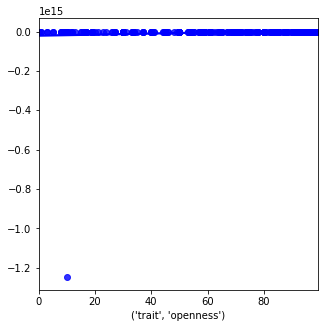


Create pipeline with linear (Fold 2 ), for trait:  openness ...

Selected features:  [('subreddit', 'marvelleaks'), ('subreddit', 'immigrationcanada'), ('subreddit', 'itthemovie'), ('subreddit', 'nintendonx'), ('subreddit', 'eaf'), ('subreddit', 'arenaofvalor'), ('subreddit', 'butehouse'), ('subreddit', 'cmhocspeaker'), ('subreddit', 'milifans'), ('subreddit', 'nuclearthrone')]

Score (R squared):  0.0009269009448434895 
Mean squared error:  4.158836807175737e+28
Coefficients: 
 [ 4.79928961e+13 -3.22573557e+14  1.39160156e-02  1.68365479e-01
 -2.42942646e+13 -3.19122314e-01 -2.36986314e+13  3.22573557e+14
  3.91542627e+13 -3.91542627e+13]


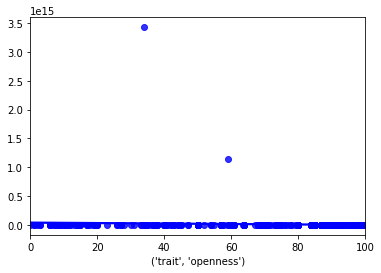


Create pipeline with linear (Fold 3 ), for trait:  openness ...

Selected features:  [('subreddit', 'egpu'), ('subreddit', 'healthinsurance'), ('subreddit', 'albiononline'), ('subreddit', 'gastate'), ('subreddit', 'dmt'), ('subreddit', 'a7x'), ('subreddit', 'justlearnedthefword'), ('subreddit', 'pomade'), ('subreddit', 'jspbwcctwasogc'), ('subreddit', 'bonsai')]

Score (R squared):  0.00229438300716589 
Mean squared error:  721.6734590238988
Coefficients: 
 [ 6.53996142e-02  2.90506607e-02  8.41407019e+13 -8.41407019e+13
 -3.95833333e-01 -1.15364583e+00  4.14178224e+13  3.43941060e+14
 -3.43941060e+14 -4.14178224e+13]


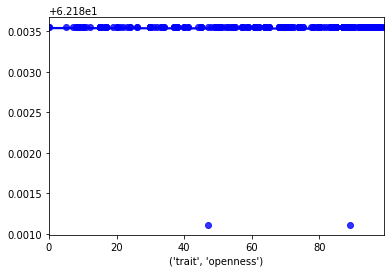


Create pipeline with linear (Fold 4 ), for trait:  openness ...

Selected features:  [('subreddit', 'evolvegamelfg'), ('subreddit', 'lcdsoundsystem'), ('subreddit', 'mahouka'), ('subreddit', 'feminist_videos'), ('subreddit', 'wearethemusicmakers'), ('subreddit', 'frozenfriends'), ('subreddit', 'glitchinthematrix'), ('subreddit', 'bitnation'), ('subreddit', 'carnivore'), ('subreddit', 'chiefkeef')]

Score (R squared):  -0.002611420825635813 
Mean squared error:  7.217990111737454e+29
Coefficients: 
 [-1.88683815e+14 -2.76690195e+13  1.88683815e+14  7.06839530e+13
  1.38337219e+13  1.38352976e+13 -7.06839530e+13  1.99621138e+13
 -1.00148155e+13 -9.94729831e+12]


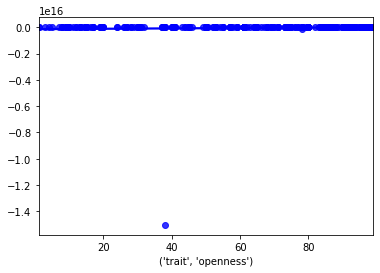


Create pipeline with linear (Fold 5 ), for trait:  openness ...

Selected features:  [('subreddit', 'celestegame'), ('subreddit', 'brum'), ('subreddit', 'nrxn'), ('subreddit', 'oregon'), ('subreddit', 'poetryspam'), ('subreddit', 'jenbretty'), ('subreddit', 'traversecity'), ('subreddit', 'hitsworthturkingfor'), ('subreddit', 'jurassicpark'), ('subreddit', 'java')]

Score (R squared):  -0.0013377425435394663 
Mean squared error:  2.135217820328916e+31
Coefficients: 
 [-7.56346382e-01 -3.15691452e+13  1.32812500e-01  1.55122750e+13
  7.16806912e+12  1.34076433e+15 -4.11132812e-01  1.60568703e+13
 -7.16806912e+12 -1.34076433e+15]


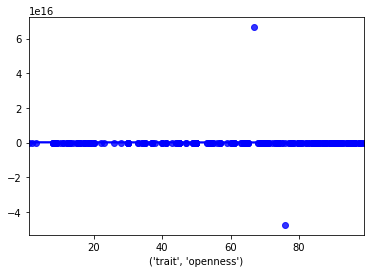

Time for entire process: 19.40s
Average score (R squared):  -0.0005550015744530956

Trait to predict:  conscientiousness 


Create pipeline with linear (Fold 1 ), for trait:  conscientiousness ...

Selected features:  [('subreddit', 'frontpage'), ('subreddit', 'giveaways'), ('subreddit', 'ladybonersgonecuddly'), ('subreddit', 'randomactsofpolish'), ('subreddit', 'watchredditdie'), ('subreddit', 'piracy'), ('subreddit', 'gwnerdy'), ('subreddit', 'princesspyrrah'), ('subreddit', 'metal'), ('subreddit', 'straightgirlsplaying')]

Score (R squared):  -0.0026471895661204226 
Mean squared error:  9.59055989949763e+26
Coefficients: 
 [ 1.10973165e+14 -4.15716657e+13  6.93251053e+12  6.92755212e+12
 -5.54865827e+13 -5.54865827e+13  6.92755212e+12  6.92755212e+12
  6.92894664e+12  6.92755212e+12]


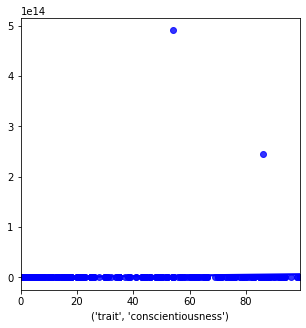


Create pipeline with linear (Fold 2 ), for trait:  conscientiousness ...

Selected features:  [('subreddit', 'mchannel4'), ('subreddit', 'headphones'), ('subreddit', 'tihi'), ('subreddit', 'spokane'), ('subreddit', 'jawbone'), ('subreddit', 'blackmetal'), ('subreddit', 'centralstatesupcourt'), ('subreddit', '2012'), ('subreddit', 'saskatoon'), ('subreddit', 'rlanguage')]

Score (R squared):  -0.0024811836214369 
Mean squared error:  3.512817049791752e+27
Coefficients: 
 [ 1.38177442e+14 -3.45464405e+13 -3.45436670e+13  2.96463061e+13
 -7.75531786e+11 -7.75531786e+11 -7.75531786e+11 -3.45436670e+13
 -3.45436670e+13 -2.73197108e+13]


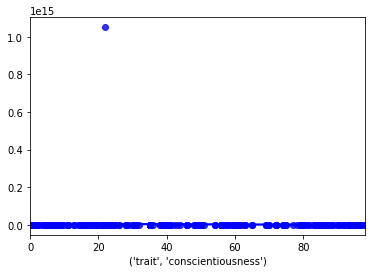


Create pipeline with linear (Fold 3 ), for trait:  conscientiousness ...

Selected features:  [('subreddit', 'cringe'), ('subreddit', 'hiddenstrapon'), ('subreddit', 'thelastofus'), ('subreddit', 'teachingresources'), ('subreddit', 'steamgiveaway'), ('subreddit', 'squidjump'), ('subreddit', 'mgmt'), ('subreddit', 'natureporn'), ('subreddit', 'learnmath'), ('subreddit', 'orphanblack')]

Score (R squared):  -0.004086773514669906 
Mean squared error:  5.8173511557427666e+29
Coefficients: 
 [ 1.34128556e+14  1.16385323e+14 -2.32452742e+13 -2.32714979e+13
 -6.70642781e+13 -6.70642781e+13  1.28662109e-01 -2.33181259e+13
 -2.32752127e+13 -2.32752127e+13]


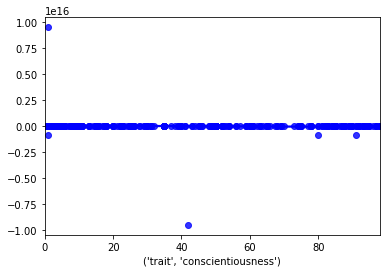


Create pipeline with linear (Fold 4 ), for trait:  conscientiousness ...

Selected features:  [('subreddit', 'phenibut'), ('subreddit', 'swordartonline'), ('subreddit', 'ask_politics'), ('subreddit', 'thesinner'), ('subreddit', 'mltp'), ('subreddit', 'mountainbiking'), ('subreddit', 'girlotakus'), ('subreddit', 'michael________'), ('subreddit', 'hitsworthturkingfor'), ('subreddit', 'mstonewall')]

Score (R squared):  -0.0011735126980425559 
Mean squared error:  4.584493688748252e+29
Coefficients: 
 [ 2.95614184e+14  3.48582970e+13 -5.11715753e+12 -1.47792511e+14
 -1.47821673e+14 -1.16213801e+13  2.36894692e+10  5.09346806e+12
 -1.16184584e+13 -1.16184584e+13]


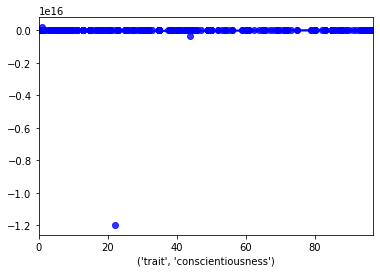


Create pipeline with linear (Fold 5 ), for trait:  conscientiousness ...

Selected features:  [('subreddit', 'keeshond'), ('subreddit', 'undelete'), ('subreddit', 'criticalrole'), ('subreddit', 'cinderdidnothingwrong'), ('subreddit', 'fffffffuuuuuuuuuuuu'), ('subreddit', 'java'), ('subreddit', 'bitcoinmining'), ('subreddit', 'modelnewsweek'), ('subreddit', 'louie'), ('subreddit', 'monsterverse')]

Score (R squared):  -0.002248925210534214 
Mean squared error:  7.312311452553169e+24
Coefficients: 
 [-9.50395926e+13  1.18806232e+13  1.18794194e+13  1.18794194e+13
  1.18806147e+13  5.84852219e-01  1.18794194e+13  1.18794194e+13
  1.18812576e+13  1.18794194e+13]


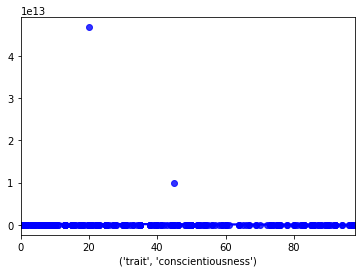

Time for entire process: 35.47s
Average score (R squared):  -0.0025275169221607996

Trait to predict:  extraversion 


Create pipeline with linear (Fold 1 ), for trait:  extraversion ...

Selected features:  [('subreddit', 'mrbuttcrack'), ('subreddit', 'galaxys10'), ('subreddit', 'thecatdimension'), ('subreddit', 'redvsblue'), ('subreddit', 'askhistory'), ('subreddit', 'rick_and_morty'), ('subreddit', 'alteredcarbon'), ('subreddit', 'sonamains'), ('subreddit', 'starshipporn'), ('subreddit', 'housekeeping')]

Score (R squared):  -3.412419281967338e-05 
Mean squared error:  901.6011190041777
Coefficients: 
 [ 2.85964252e+13 -1.42976358e+13  1.35204768e+13  8.62520218e-01
 -1.42987895e+13  2.36500122e+13 -2.36500122e+13 -1.35204768e+13
 -3.39456994e+13  3.39456994e+13]


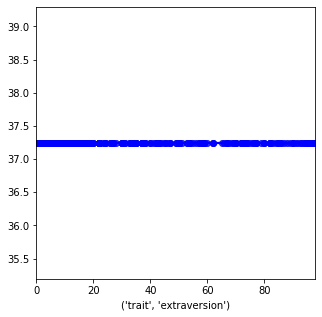


Create pipeline with linear (Fold 2 ), for trait:  extraversion ...

Selected features:  [('subreddit', 'itthemovie'), ('subreddit', 'dragons'), ('subreddit', 'openwrt'), ('subreddit', 't60srebelthreads'), ('subreddit', 'eaf'), ('subreddit', 'mholbills'), ('subreddit', 'apusilicon'), ('subreddit', 'butehouse'), ('subreddit', 'milifans'), ('subreddit', 'nuclearthrone')]

Score (R squared):  0.00013214133768069125 
Mean squared error:  987.9141181542417
Coefficients: 
 [ 6.97877750e-01  5.34123702e+13  9.58984375e-01 -2.66260168e+13
 -4.21025872e+13  3.98437500e-01 -2.67863533e+13  4.21025872e+13
  7.89423782e+13 -7.89423782e+13]


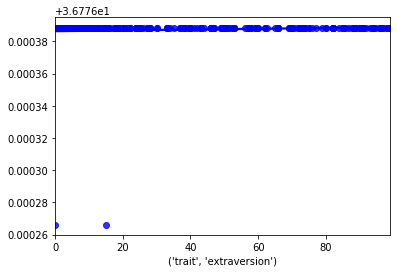


Create pipeline with linear (Fold 3 ), for trait:  extraversion ...

Selected features:  [('subreddit', 'modelcentralstate'), ('subreddit', 'cummingonfigurines'), ('subreddit', 'socalr4r'), ('subreddit', 'engrish'), ('subreddit', 'tyrannygame'), ('subreddit', 'pomade'), ('subreddit', 'farscape'), ('subreddit', 'jspbwcctwasogc'), ('subreddit', 'imaginarywarhammer'), ('subreddit', 'ainbow')]

Score (R squared):  0.0003749773551382507 
Mean squared error:  1.1834819276180585e+29
Coefficients: 
 [ 7.12875084e-01  6.63533298e+13  1.13085938e+00  1.70347858e+14
 -1.70347858e+14 -6.79963576e+13  4.96093750e-01  6.79963576e+13
 -3.22555481e+13 -3.40977817e+13]


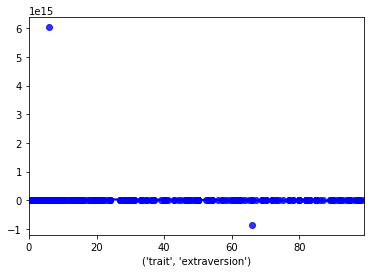


Create pipeline with linear (Fold 4 ), for trait:  extraversion ...

Selected features:  [('subreddit', 'aclfestival'), ('subreddit', 'wearethemusicmakers'), ('subreddit', 'standupworkshop'), ('subreddit', 'sony'), ('subreddit', 'piracy'), ('subreddit', 'frozenfriends'), ('subreddit', 'glitchinthematrix'), ('subreddit', 'bitnation'), ('subreddit', 'carnivore'), ('subreddit', 'chiefkeef')]

Score (R squared):  -0.00025464798305074865 
Mean squared error:  9.806462584002108e+25
Coefficients: 
 [ 3.15207286e+13 -1.60158990e+13 -3.15207286e+13  5.85047159e+13
 -5.85047159e+13  1.60158990e+13  6.80057526e-01 -2.96907973e+13
  1.48603362e+13  1.48304611e+13]


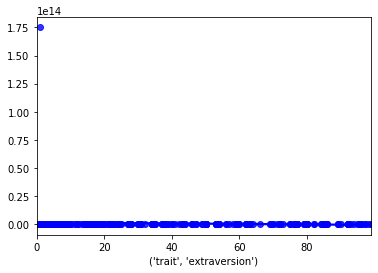


Create pipeline with linear (Fold 5 ), for trait:  extraversion ...

Selected features:  [('subreddit', 'awwww'), ('subreddit', 'brum'), ('subreddit', 'oregon'), ('subreddit', 'poetryspam'), ('subreddit', 'bloomington'), ('subreddit', 'hitsworthturkingfor'), ('subreddit', 'mhocjusticesc'), ('subreddit', 'meanjokes'), ('subreddit', 'jurassicpark'), ('subreddit', 'beerandpizza')]

Score (R squared):  -0.0011262112168961558 
Mean squared error:  906.5520830264154
Coefficients: 
 [-3.89439609e+13  2.24544216e+13 -1.11590031e+13  1.93946085e+13
  6.88040201e+13 -1.12954185e+13  5.24513129e+13 -5.24513129e+13
  1.95493524e+13 -6.88040201e+13]


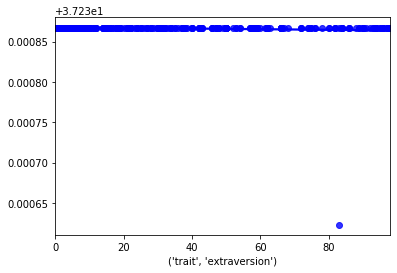

Time for entire process: 51.46s
Average score (R squared):  -0.00018157293998952718

Trait to predict:  agreeableness 


Create pipeline with linear (Fold 1 ), for trait:  agreeableness ...

Selected features:  [('subreddit', 'badmtgcombos'), ('subreddit', 'thecatdimension'), ('subreddit', 'stock'), ('subreddit', 'skyrimtogether'), ('subreddit', 'sonamains'), ('subreddit', 'eastenders'), ('subreddit', 'mhoccsstest'), ('subreddit', 'granblue_en'), ('subreddit', 'ask_political_science'), ('subreddit', 'inceltears')]

Score (R squared):  -0.001394612412244589 
Mean squared error:  8.79692703293243e+28
Coefficients: 
 [ 2.81572587e-01 -2.30504005e+13 -5.46568027e+13 -1.04555915e+13
  2.30504005e+13  2.96714188e+14 -1.48366252e+14  3.25561971e+13
  3.25561971e+13 -1.48347936e+14]


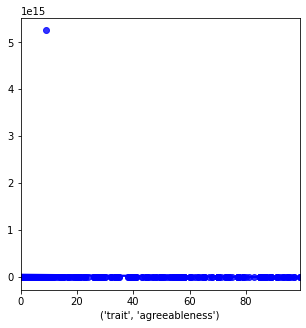


Create pipeline with linear (Fold 2 ), for trait:  agreeableness ...

Selected features:  [('subreddit', 'timetravel'), ('subreddit', 'itthemovie'), ('subreddit', 'eaf'), ('subreddit', 'logitechg'), ('subreddit', 'hanassholesolo'), ('subreddit', 'butehouse'), ('subreddit', 'nasdanq'), ('subreddit', 'snp'), ('subreddit', 'clonazoland'), ('subreddit', 'georgism')]

Score (R squared):  -0.0007126318218078076 
Mean squared error:  961.2897048338559
Coefficients: 
 [-7.42464168e+13  3.00781250e-01  2.52987491e+13  1.21907348e+13
  1.21907348e+13 -2.52987491e+13  1.21934903e+13  1.21934903e+13
  1.21913733e+13  1.32865931e+13]


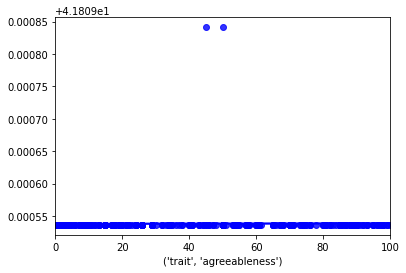


Create pipeline with linear (Fold 3 ), for trait:  agreeableness ...

Selected features:  [('subreddit', 'povertyfinance'), ('subreddit', 'frontend'), ('subreddit', '944'), ('subreddit', 'onetrueprovo'), ('subreddit', 'mltp'), ('subreddit', 'overwatchlft'), ('subreddit', 'sonm'), ('subreddit', 'insurgency'), ('subreddit', 'morbidreality'), ('subreddit', 'egpu')]

Score (R squared):  0.0009311589580383028 
Mean squared error:  996.2425352796674
Coefficients: 
 [-2.19076010e+14  1.24915593e+14  8.94393921e-01 -8.70310591e+13
  2.19076010e+14 -1.24915593e+14  4.78529322e+13  3.91781269e+13
  4.24911499e-01  2.80410767e-01]


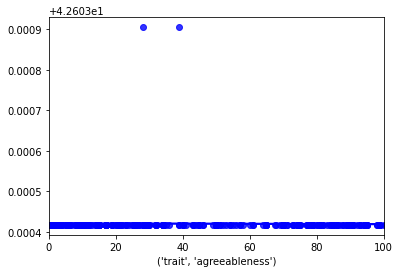


Create pipeline with linear (Fold 4 ), for trait:  agreeableness ...

Selected features:  [('subreddit', 'thelse'), ('subreddit', 'thesinner'), ('subreddit', 'mltp'), ('subreddit', 'transgenderuk'), ('subreddit', 'lcdsoundsystem'), ('subreddit', 'terraria'), ('subreddit', 'feminist_videos'), ('subreddit', 'wearethemusicmakers'), ('subreddit', 'frozenfriends'), ('subreddit', 'glitchinthematrix')]

Score (R squared):  0.00017677086912903928 
Mean squared error:  8.870099789496848e+29
Coefficients: 
 [ 9.64804179e-01 -7.45235062e+13  7.45235062e+13  8.47656250e-01
 -1.56319122e+14  4.41406250e-01  7.30354957e+13  7.71614576e+13
  7.91576645e+13 -7.30354957e+13]


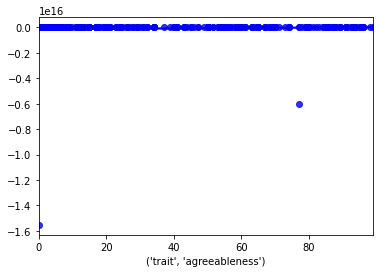


Create pipeline with linear (Fold 5 ), for trait:  agreeableness ...

Selected features:  [('subreddit', 'manholeporn'), ('subreddit', 'mhocgreensskype'), ('subreddit', 'poetryspam'), ('subreddit', 'jenbretty'), ('subreddit', 'git'), ('subreddit', 'mholbills'), ('subreddit', 'jurassicpark'), ('subreddit', 'java'), ('subreddit', '8rack'), ('subreddit', 'gigantic')]

Score (R squared):  0.0010134745129979361 
Mean squared error:  1.5500563562872414e+28
Coefficients: 
 [ 4.42067951e-01  4.44599498e+12 -9.95932501e+12  3.61247708e+13
 -1.10941259e+12 -1.11219416e+12  9.95932501e+12 -3.61247708e+13
 -1.11219416e+12 -1.11219407e+12]


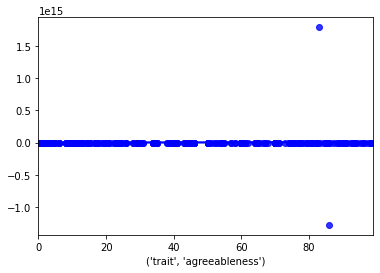

Time for entire process: 67.19s
Average score (R squared):  2.8320212225763088e-06

Trait to predict:  neuroticism 


Create pipeline with linear (Fold 1 ), for trait:  neuroticism ...

Selected features:  [('subreddit', 'chicagonoire'), ('subreddit', 'disneyvacation'), ('subreddit', 'lafc'), ('subreddit', 'mrbuttcrack'), ('subreddit', 'galaxys10'), ('subreddit', 'thecatdimension'), ('subreddit', 'askhistory'), ('subreddit', 'sonamains'), ('subreddit', 'starshipporn'), ('subreddit', 'housekeeping')]

Score (R squared):  -0.0006295745809841158 
Mean squared error:  1.5231366974898421e+22
Coefficients: 
 [-6.06062948e+13  2.17025550e+11  4.36273488e+12  2.02032877e+13
  2.02014673e+13  3.00514776e+11  2.02015398e+13 -4.66324966e+12
 -1.08512772e+11 -1.08512777e+11]


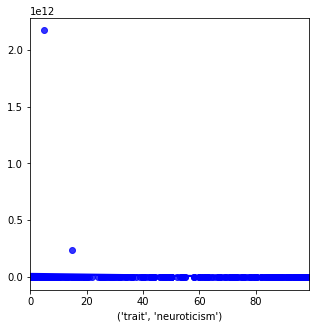


Create pipeline with linear (Fold 2 ), for trait:  neuroticism ...

Selected features:  [('subreddit', 'marvelleaks'), ('subreddit', 'dragons'), ('subreddit', 't60srebelthreads'), ('subreddit', 'eaf'), ('subreddit', 'apusilicon'), ('subreddit', 'mechanicalheadpens'), ('subreddit', 'butehouse'), ('subreddit', 'bostontrees'), ('subreddit', 'milifans'), ('subreddit', 'nuclearthrone')]

Score (R squared):  -0.0031508627467005113 
Mean squared error:  1072.1370851787958
Coefficients: 
 [-6.43054468e+13  1.28502008e+14 -6.47706990e+13  3.24353604e+13
 -6.37313089e+13 -3.67340088e-01  3.18700864e+13  2.20565796e-02
 -1.98204525e+14  1.98204525e+14]


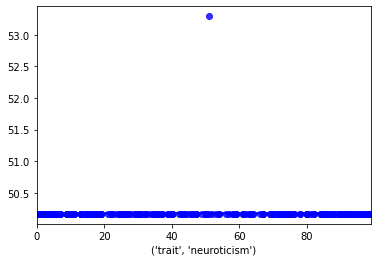


Create pipeline with linear (Fold 3 ), for trait:  neuroticism ...

Selected features:  [('subreddit', 'unexpectedcommunism'), ('subreddit', 'psychedelics'), ('subreddit', 'halifax'), ('subreddit', '300blk'), ('subreddit', 'rightist'), ('subreddit', 'frontend'), ('subreddit', 'overwatchlft'), ('subreddit', 'wec'), ('subreddit', 'pomade'), ('subreddit', 'jspbwcctwasogc')]

Score (R squared):  -0.002091270901622755 
Mean squared error:  1049.811390415191
Coefficients: 
 [-8.62052191e+13  2.26039356e+15  2.85739598e+13 -5.64707948e+14
 -5.64707948e+14 -5.64707948e+14 -5.66269718e+14  9.33837891e-02
  2.88156296e+13  2.88156296e+13]


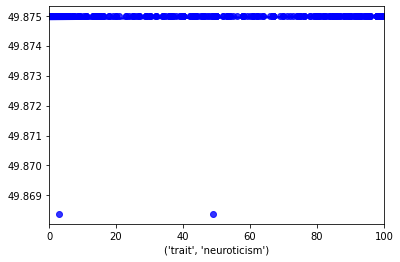


Create pipeline with linear (Fold 4 ), for trait:  neuroticism ...

Selected features:  [('subreddit', 'lcdsoundsystem'), ('subreddit', 'sylvanesso'), ('subreddit', 'aclfestival'), ('subreddit', 'wearethemusicmakers'), ('subreddit', 'standupworkshop'), ('subreddit', 'twosentencehorror'), ('subreddit', 'frozenfriends'), ('subreddit', 'bitnation'), ('subreddit', 'carnivore'), ('subreddit', 'chiefkeef')]

Score (R squared):  -0.0004586356236782052 
Mean squared error:  1.561485391934076e+23
Coefficients: 
 [ 7.92396889e+13  2.30485699e+13 -1.14999789e+13 -3.96231857e+13
 -1.15485910e+13 -3.46580505e-01 -3.96165032e+13  1.18360029e+12
 -5.91810552e+11 -5.91789736e+11]


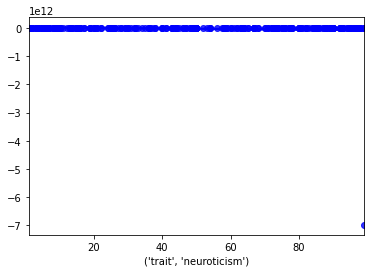


Create pipeline with linear (Fold 5 ), for trait:  neuroticism ...

Selected features:  [('subreddit', 'map_porn'), ('subreddit', 'hitman'), ('subreddit', 'blackwakegame'), ('subreddit', 'awwww'), ('subreddit', 'brum'), ('subreddit', 'oregon'), ('subreddit', 'poetryspam'), ('subreddit', 'hitsworthturkingfor'), ('subreddit', 'egg_irl'), ('subreddit', 'jurassicpark')]

Score (R squared):  0.00041036207683031733 
Mean squared error:  1030.3319826741808
Coefficients: 
 [ 7.94949476e+13  2.10937500e-01  1.07361984e+00  3.62953910e+11
 -2.64983053e+13 -2.64983265e+13 -3.10133754e+10 -2.64983158e+13
 -3.37238312e-01 -3.31940534e+11]


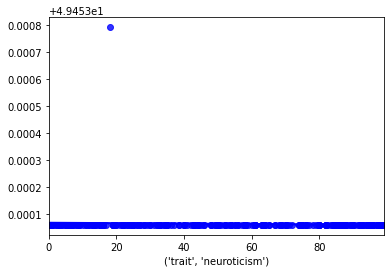

Time for entire process: 82.79s
Average score (R squared):  -0.0011839963552310539
Classifier:  rfc_reg 


Trait to predict:  openness 


Create pipeline with rfc_reg (Fold 1 ), for trait:  openness ...

Selected features:  [('subreddit', 'kendo'), ('subreddit', 'badmtgcombos'), ('subreddit', 'colorizationrequests'), ('subreddit', 'thecatdimension'), ('subreddit', 'subredditdrama'), ('subreddit', 'sonamains'), ('subreddit', 'u_wilsonjason'), ('subreddit', 'globalpowers'), ('subreddit', 'starshipporn'), ('subreddit', 'housekeeping')]

Score (R squared):  0.0004441234681260564 
Mean squared error:  763.0819460501298


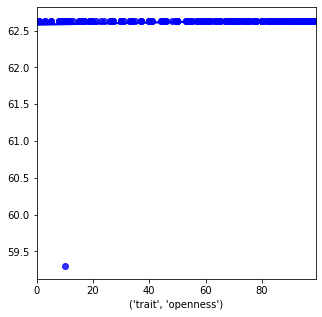


Create pipeline with rfc_reg (Fold 2 ), for trait:  openness ...

Selected features:  [('subreddit', 'marvelleaks'), ('subreddit', 'immigrationcanada'), ('subreddit', 'itthemovie'), ('subreddit', 'nintendonx'), ('subreddit', 'eaf'), ('subreddit', 'arenaofvalor'), ('subreddit', 'butehouse'), ('subreddit', 'cmhocspeaker'), ('subreddit', 'milifans'), ('subreddit', 'nuclearthrone')]

Score (R squared):  0.003385964940171182 
Mean squared error:  816.0617123277793


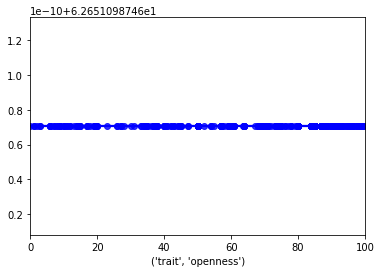


Create pipeline with rfc_reg (Fold 3 ), for trait:  openness ...

Selected features:  [('subreddit', 'egpu'), ('subreddit', 'healthinsurance'), ('subreddit', 'albiononline'), ('subreddit', 'gastate'), ('subreddit', 'dmt'), ('subreddit', 'a7x'), ('subreddit', 'justlearnedthefword'), ('subreddit', 'pomade'), ('subreddit', 'jspbwcctwasogc'), ('subreddit', 'bonsai')]

Score (R squared):  0.003968994914273827 
Mean squared error:  722.2986269523192


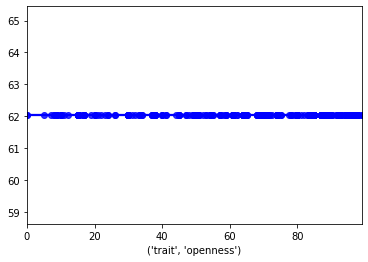


Create pipeline with rfc_reg (Fold 4 ), for trait:  openness ...

Selected features:  [('subreddit', 'evolvegamelfg'), ('subreddit', 'lcdsoundsystem'), ('subreddit', 'mahouka'), ('subreddit', 'feminist_videos'), ('subreddit', 'wearethemusicmakers'), ('subreddit', 'frozenfriends'), ('subreddit', 'glitchinthematrix'), ('subreddit', 'bitnation'), ('subreddit', 'carnivore'), ('subreddit', 'chiefkeef')]

Score (R squared):  0.0007333778104620103 
Mean squared error:  785.0102043286149


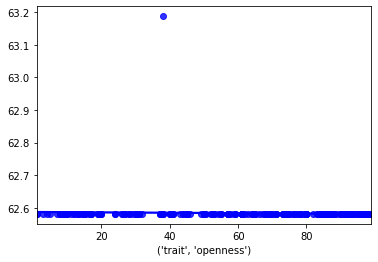


Create pipeline with rfc_reg (Fold 5 ), for trait:  openness ...

Selected features:  [('subreddit', 'celestegame'), ('subreddit', 'brum'), ('subreddit', 'nrxn'), ('subreddit', 'oregon'), ('subreddit', 'poetryspam'), ('subreddit', 'jenbretty'), ('subreddit', 'traversecity'), ('subreddit', 'hitsworthturkingfor'), ('subreddit', 'jurassicpark'), ('subreddit', 'java')]

Score (R squared):  0.0008549639436662426 
Mean squared error:  779.1544540708509


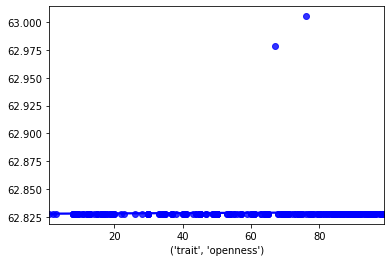

Time for entire process: 100.99s
Average score (R squared):  0.0018774850153398636

Trait to predict:  conscientiousness 


Create pipeline with rfc_reg (Fold 1 ), for trait:  conscientiousness ...

Selected features:  [('subreddit', 'frontpage'), ('subreddit', 'giveaways'), ('subreddit', 'ladybonersgonecuddly'), ('subreddit', 'randomactsofpolish'), ('subreddit', 'watchredditdie'), ('subreddit', 'piracy'), ('subreddit', 'gwnerdy'), ('subreddit', 'princesspyrrah'), ('subreddit', 'metal'), ('subreddit', 'straightgirlsplaying')]

Score (R squared):  2.917859998929906e-05 
Mean squared error:  869.731177226182


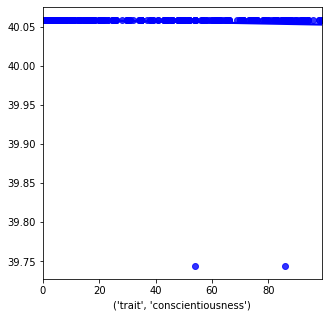


Create pipeline with rfc_reg (Fold 2 ), for trait:  conscientiousness ...

Selected features:  [('subreddit', 'mchannel4'), ('subreddit', 'headphones'), ('subreddit', 'tihi'), ('subreddit', 'spokane'), ('subreddit', 'jawbone'), ('subreddit', 'blackmetal'), ('subreddit', 'centralstatesupcourt'), ('subreddit', '2012'), ('subreddit', 'saskatoon'), ('subreddit', 'rlanguage')]

Score (R squared):  0.00027836906976275166 
Mean squared error:  978.2931494411196


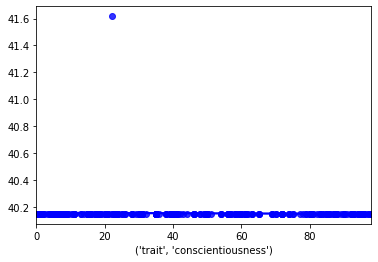


Create pipeline with rfc_reg (Fold 3 ), for trait:  conscientiousness ...

Selected features:  [('subreddit', 'cringe'), ('subreddit', 'hiddenstrapon'), ('subreddit', 'thelastofus'), ('subreddit', 'teachingresources'), ('subreddit', 'steamgiveaway'), ('subreddit', 'squidjump'), ('subreddit', 'mgmt'), ('subreddit', 'natureporn'), ('subreddit', 'learnmath'), ('subreddit', 'orphanblack')]

Score (R squared):  1.786804301706635e-05 
Mean squared error:  1009.3510319029806


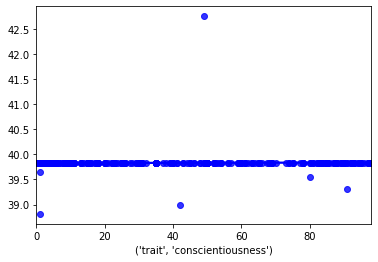


Create pipeline with rfc_reg (Fold 4 ), for trait:  conscientiousness ...

Selected features:  [('subreddit', 'phenibut'), ('subreddit', 'swordartonline'), ('subreddit', 'ask_politics'), ('subreddit', 'thesinner'), ('subreddit', 'mltp'), ('subreddit', 'mountainbiking'), ('subreddit', 'girlotakus'), ('subreddit', 'michael________'), ('subreddit', 'hitsworthturkingfor'), ('subreddit', 'mstonewall')]

Score (R squared):  0.0004953960027096471 
Mean squared error:  894.6438110392045


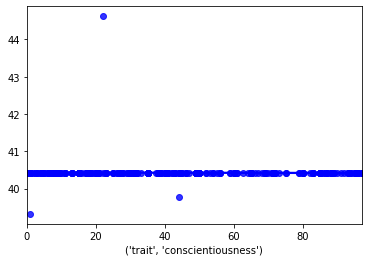


Create pipeline with rfc_reg (Fold 5 ), for trait:  conscientiousness ...

Selected features:  [('subreddit', 'keeshond'), ('subreddit', 'undelete'), ('subreddit', 'criticalrole'), ('subreddit', 'cinderdidnothingwrong'), ('subreddit', 'fffffffuuuuuuuuuuuu'), ('subreddit', 'java'), ('subreddit', 'bitcoinmining'), ('subreddit', 'modelnewsweek'), ('subreddit', 'louie'), ('subreddit', 'monsterverse')]

Score (R squared):  0.00033934159378945505 
Mean squared error:  863.4747272783302


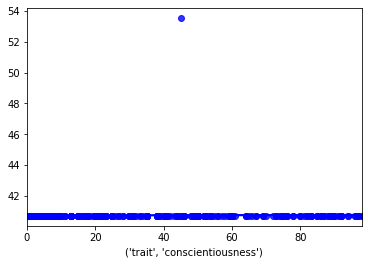

Time for entire process: 119.07s
Average score (R squared):  0.00023203066185364384

Trait to predict:  extraversion 


Create pipeline with rfc_reg (Fold 1 ), for trait:  extraversion ...

Selected features:  [('subreddit', 'mrbuttcrack'), ('subreddit', 'galaxys10'), ('subreddit', 'thecatdimension'), ('subreddit', 'redvsblue'), ('subreddit', 'askhistory'), ('subreddit', 'rick_and_morty'), ('subreddit', 'alteredcarbon'), ('subreddit', 'sonamains'), ('subreddit', 'starshipporn'), ('subreddit', 'housekeeping')]

Score (R squared):  0.0012143491121973105 
Mean squared error:  901.7285884482535


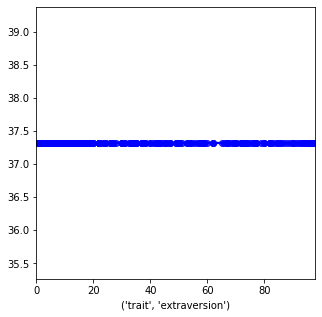


Create pipeline with rfc_reg (Fold 2 ), for trait:  extraversion ...

Selected features:  [('subreddit', 'itthemovie'), ('subreddit', 'dragons'), ('subreddit', 'openwrt'), ('subreddit', 't60srebelthreads'), ('subreddit', 'eaf'), ('subreddit', 'mholbills'), ('subreddit', 'apusilicon'), ('subreddit', 'butehouse'), ('subreddit', 'milifans'), ('subreddit', 'nuclearthrone')]

Score (R squared):  0.0014868235368948879 
Mean squared error:  987.7488347528199


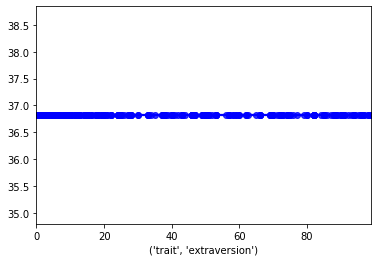


Create pipeline with rfc_reg (Fold 3 ), for trait:  extraversion ...

Selected features:  [('subreddit', 'modelcentralstate'), ('subreddit', 'cummingonfigurines'), ('subreddit', 'socalr4r'), ('subreddit', 'engrish'), ('subreddit', 'tyrannygame'), ('subreddit', 'pomade'), ('subreddit', 'farscape'), ('subreddit', 'jspbwcctwasogc'), ('subreddit', 'imaginarywarhammer'), ('subreddit', 'ainbow')]

Score (R squared):  0.002492670048756751 
Mean squared error:  923.1607570357737


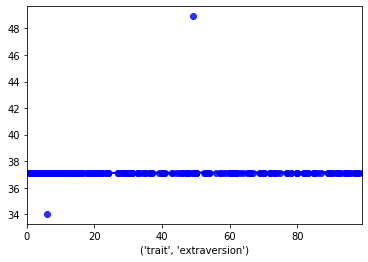


Create pipeline with rfc_reg (Fold 4 ), for trait:  extraversion ...

Selected features:  [('subreddit', 'aclfestival'), ('subreddit', 'wearethemusicmakers'), ('subreddit', 'standupworkshop'), ('subreddit', 'sony'), ('subreddit', 'piracy'), ('subreddit', 'frozenfriends'), ('subreddit', 'glitchinthematrix'), ('subreddit', 'bitnation'), ('subreddit', 'carnivore'), ('subreddit', 'chiefkeef')]

Score (R squared):  0.0009536985190540248 
Mean squared error:  914.1554022610661


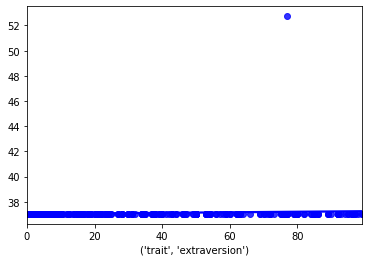


Create pipeline with rfc_reg (Fold 5 ), for trait:  extraversion ...

Selected features:  [('subreddit', 'awwww'), ('subreddit', 'brum'), ('subreddit', 'oregon'), ('subreddit', 'poetryspam'), ('subreddit', 'bloomington'), ('subreddit', 'hitsworthturkingfor'), ('subreddit', 'mhocjusticesc'), ('subreddit', 'meanjokes'), ('subreddit', 'jurassicpark'), ('subreddit', 'beerandpizza')]

Score (R squared):  0.0006501789069314201 
Mean squared error:  906.489127427288


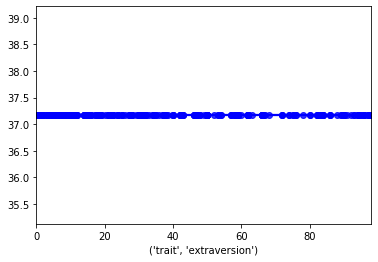

Time for entire process: 136.90s
Average score (R squared):  0.001359544024766879

Trait to predict:  agreeableness 


Create pipeline with rfc_reg (Fold 1 ), for trait:  agreeableness ...

Selected features:  [('subreddit', 'badmtgcombos'), ('subreddit', 'thecatdimension'), ('subreddit', 'stock'), ('subreddit', 'skyrimtogether'), ('subreddit', 'sonamains'), ('subreddit', 'eastenders'), ('subreddit', 'mhoccsstest'), ('subreddit', 'granblue_en'), ('subreddit', 'ask_political_science'), ('subreddit', 'inceltears')]

Score (R squared):  0.0004779852726203293 
Mean squared error:  927.5775178106836


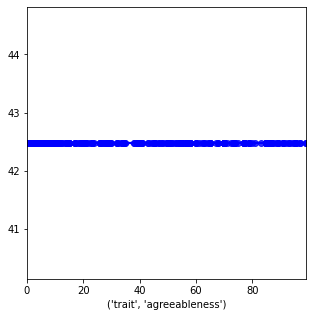


Create pipeline with rfc_reg (Fold 2 ), for trait:  agreeableness ...

Selected features:  [('subreddit', 'timetravel'), ('subreddit', 'itthemovie'), ('subreddit', 'eaf'), ('subreddit', 'logitechg'), ('subreddit', 'hanassholesolo'), ('subreddit', 'butehouse'), ('subreddit', 'nasdanq'), ('subreddit', 'snp'), ('subreddit', 'clonazoland'), ('subreddit', 'georgism')]

Score (R squared):  0.0006090097607339695 
Mean squared error:  961.585292465174


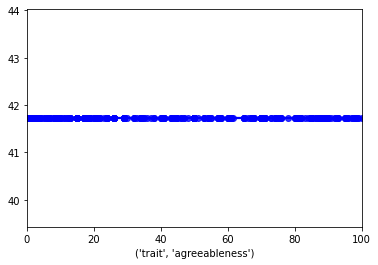


Create pipeline with rfc_reg (Fold 3 ), for trait:  agreeableness ...

Selected features:  [('subreddit', 'povertyfinance'), ('subreddit', 'frontend'), ('subreddit', '944'), ('subreddit', 'onetrueprovo'), ('subreddit', 'mltp'), ('subreddit', 'overwatchlft'), ('subreddit', 'sonm'), ('subreddit', 'insurgency'), ('subreddit', 'morbidreality'), ('subreddit', 'egpu')]

Score (R squared):  0.002027428275360732 
Mean squared error:  995.7675695343439


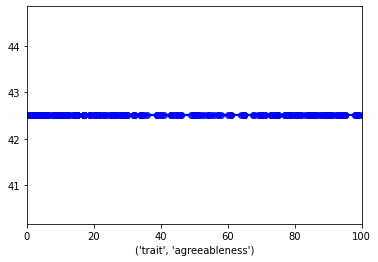


Create pipeline with rfc_reg (Fold 4 ), for trait:  agreeableness ...

Selected features:  [('subreddit', 'thelse'), ('subreddit', 'thesinner'), ('subreddit', 'mltp'), ('subreddit', 'transgenderuk'), ('subreddit', 'lcdsoundsystem'), ('subreddit', 'terraria'), ('subreddit', 'feminist_videos'), ('subreddit', 'wearethemusicmakers'), ('subreddit', 'frozenfriends'), ('subreddit', 'glitchinthematrix')]

Score (R squared):  0.002220449053967677 
Mean squared error:  980.8582703219636


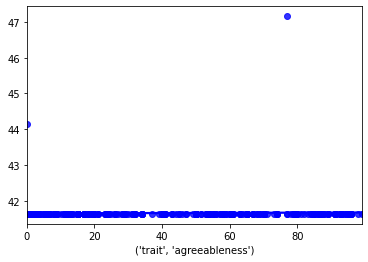


Create pipeline with rfc_reg (Fold 5 ), for trait:  agreeableness ...

Selected features:  [('subreddit', 'manholeporn'), ('subreddit', 'mhocgreensskype'), ('subreddit', 'poetryspam'), ('subreddit', 'jenbretty'), ('subreddit', 'git'), ('subreddit', 'mholbills'), ('subreddit', 'jurassicpark'), ('subreddit', 'java'), ('subreddit', '8rack'), ('subreddit', 'gigantic')]

Score (R squared):  0.0009619757442502763 
Mean squared error:  928.4592357514825


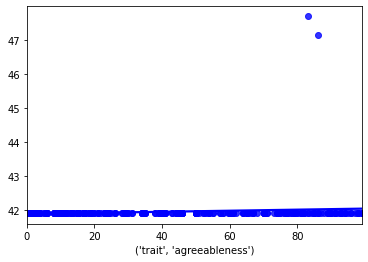

Time for entire process: 154.63s
Average score (R squared):  0.0012593696213865969

Trait to predict:  neuroticism 


Create pipeline with rfc_reg (Fold 1 ), for trait:  neuroticism ...

Selected features:  [('subreddit', 'chicagonoire'), ('subreddit', 'disneyvacation'), ('subreddit', 'lafc'), ('subreddit', 'mrbuttcrack'), ('subreddit', 'galaxys10'), ('subreddit', 'thecatdimension'), ('subreddit', 'askhistory'), ('subreddit', 'sonamains'), ('subreddit', 'starshipporn'), ('subreddit', 'housekeeping')]

Score (R squared):  0.0010261846834230814 
Mean squared error:  1061.6804533542893


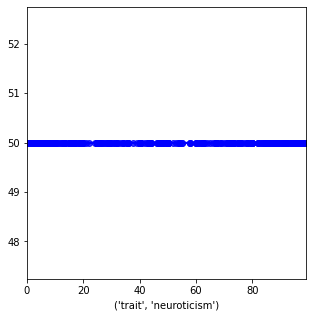


Create pipeline with rfc_reg (Fold 2 ), for trait:  neuroticism ...

Selected features:  [('subreddit', 'marvelleaks'), ('subreddit', 'dragons'), ('subreddit', 't60srebelthreads'), ('subreddit', 'eaf'), ('subreddit', 'apusilicon'), ('subreddit', 'mechanicalheadpens'), ('subreddit', 'butehouse'), ('subreddit', 'bostontrees'), ('subreddit', 'milifans'), ('subreddit', 'nuclearthrone')]

Score (R squared):  0.0010520729863924272 
Mean squared error:  1071.4354307735796


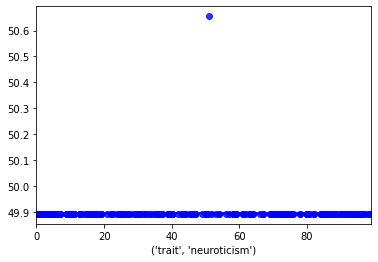


Create pipeline with rfc_reg (Fold 3 ), for trait:  neuroticism ...

Selected features:  [('subreddit', 'unexpectedcommunism'), ('subreddit', 'psychedelics'), ('subreddit', 'halifax'), ('subreddit', '300blk'), ('subreddit', 'rightist'), ('subreddit', 'frontend'), ('subreddit', 'overwatchlft'), ('subreddit', 'wec'), ('subreddit', 'pomade'), ('subreddit', 'jspbwcctwasogc')]

Score (R squared):  0.0012056573375462953 
Mean squared error:  1049.8412729658926


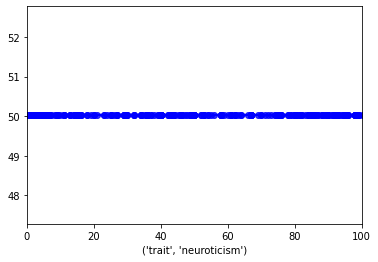


Create pipeline with rfc_reg (Fold 4 ), for trait:  neuroticism ...

Selected features:  [('subreddit', 'lcdsoundsystem'), ('subreddit', 'sylvanesso'), ('subreddit', 'aclfestival'), ('subreddit', 'wearethemusicmakers'), ('subreddit', 'standupworkshop'), ('subreddit', 'twosentencehorror'), ('subreddit', 'frozenfriends'), ('subreddit', 'bitnation'), ('subreddit', 'carnivore'), ('subreddit', 'chiefkeef')]

Score (R squared):  0.0011450133534671725 
Mean squared error:  1023.578188476614


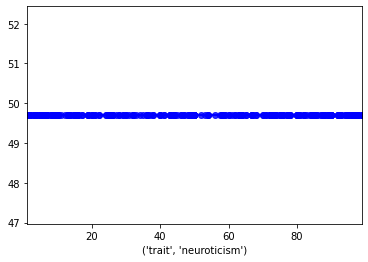


Create pipeline with rfc_reg (Fold 5 ), for trait:  neuroticism ...

Selected features:  [('subreddit', 'map_porn'), ('subreddit', 'hitman'), ('subreddit', 'blackwakegame'), ('subreddit', 'awwww'), ('subreddit', 'brum'), ('subreddit', 'oregon'), ('subreddit', 'poetryspam'), ('subreddit', 'hitsworthturkingfor'), ('subreddit', 'egg_irl'), ('subreddit', 'jurassicpark')]

Score (R squared):  0.001917464146521053 
Mean squared error:  1029.9560838247219


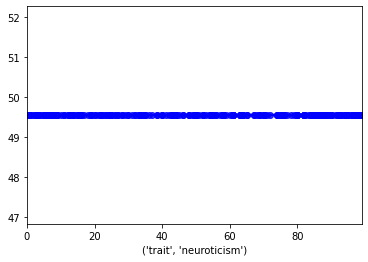

Time for entire process: 172.73s
Average score (R squared):  0.001269278501470006


In [19]:
classify_cv(df, big5_traits, 'linear', regres, 'anova', dim=False, n_feat=10)

Linear regression: 


  0%|          | 0/2 [00:00<?, ?it/s]

Classifier:  linear 


Trait to predict:  openness 


Create pipeline with linear (Fold 1 ), for trait:  openness ...


Score (R squared):  0.1100627667128311 
Mean squared error:  3684.1668681205792
Coefficients: 
 [-0.005601   -0.0165765  -0.18526022  0.03646125 -0.02668009 -0.05791315
  0.02105197 -0.08681577 -0.07953057 -0.07004194  0.01398182  0.13583343
  0.03910185 -0.06396556 -0.01645944 -0.19380413  0.13948264 -0.01048483
  0.16757679 -0.01022256 -0.21709494  0.0856582   0.12568026 -0.03327303
  0.12411478 -0.13641069  0.24628335 -0.22983974  0.17545417 -0.03353305
  0.09983997 -0.12610721 -0.14061536 -0.0489441  -0.00928902 -0.00713084
  0.07844406 -0.06354072  0.19497444  0.0648102   0.19641659 -0.05823384
  0.04971629 -0.07059622  0.07580833  0.01818747  0.02108116  0.16908962
 -0.03660547 -0.13485333 -0.15020155  0.0239655   0.21643292  0.01300464
 -0.0126141  -0.02848889  0.08727984  0.14416194 -0.02119822  0.02593912
 -0.15673137  0.11888328  0.01522567 -0.01823626  0.11

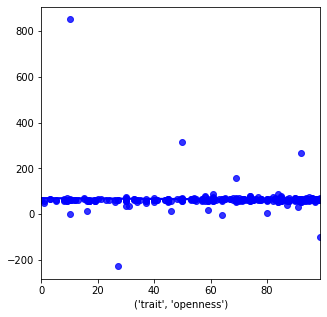


Create pipeline with linear (Fold 2 ), for trait:  openness ...


Score (R squared):  0.12600413376872543 
Mean squared error:  12382.164650451048
Coefficients: 
 [-0.01225777 -0.10283879 -0.05423651  0.02456832 -0.03596679  0.01624034
  0.08639713 -0.02751943 -0.12270982 -0.04006045 -0.05480666  0.15764099
  0.0889411  -0.02430939 -0.05123871 -0.05194485 -0.17975586 -0.05881321
  0.06553822 -0.03507798  0.10763781  0.27703961 -0.25129847  0.03361327
 -0.2986023  -0.01031993 -0.02905612 -0.01170439  0.18291167 -0.17388245
 -0.13363741 -0.02209489  0.13281246  0.0621564  -0.13798586 -0.1205166
 -0.00227067 -0.0247503   0.13097835  0.05663264 -0.12255784  0.03034085
  0.00470585 -0.33235024  0.15728335  0.07479294  0.08577158 -0.08733943
 -0.07161137 -0.14099186 -0.06035973 -0.07715565 -0.01055118  0.05316788
  0.03447673  0.23723521 -0.11446313 -0.04424491  0.08845231 -0.00241276
 -0.07318851  0.0296124  -0.2262413   0.04441221  0.08286606  0.28411214
 -0.01470039 -0.0975935   0.042797

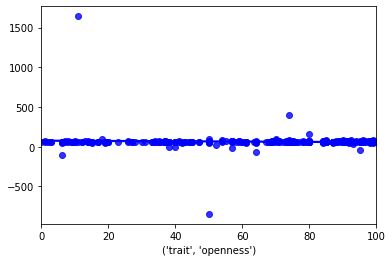


Create pipeline with linear (Fold 3 ), for trait:  openness ...


Score (R squared):  0.12034199511287236 
Mean squared error:  4693.157389418726
Coefficients: 
 [ 0.01034124  0.00262621 -0.06796432 -0.04206684  0.09683333  0.01402772
 -0.02909621  0.07668472  0.02987578 -0.11285274  0.01536465 -0.01556927
 -0.11341308  0.15629434  0.03983709  0.04111908 -0.0214592  -0.16170184
  0.03139527  0.00461425 -0.07256769  0.26630312 -0.07551019 -0.18775052
 -0.004245   -0.31841081 -0.09550943  0.02685579  0.08334855 -0.0285264
 -0.00879629  0.06810679 -0.2561963   0.13719847 -0.04960698  0.05989997
  0.25714053 -0.08790586 -0.05196343 -0.01315814 -0.069799    0.03951697
  0.19704157  0.14513405 -0.13844356  0.01933086 -0.1138364  -0.01785298
  0.12618026 -0.11144015 -0.24327075 -0.14480533 -0.07604096 -0.05331959
  0.02442174 -0.04333704  0.06307447  0.08030659  0.37632316 -0.00982504
 -0.19937706 -0.05336998  0.23294213 -0.05161211  0.20019555  0.05221815
 -0.01484862 -0.00082802  0.0306520

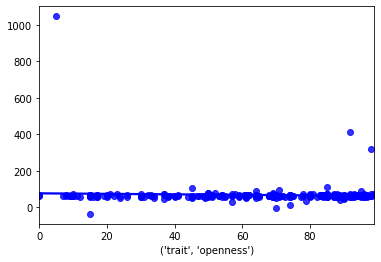


Create pipeline with linear (Fold 4 ), for trait:  openness ...


Score (R squared):  0.1064537848517636 
Mean squared error:  794.7222481682466
Coefficients: 
 [ 0.00107854 -0.06762723 -0.0312131  -0.04450941  0.07564568  0.00047218
 -0.05288986  0.03380338 -0.10244524 -0.04735936 -0.03206779 -0.02398078
 -0.09066335  0.13544176 -0.07142573  0.05410109  0.02455831 -0.18802077
 -0.16088015  0.06364195 -0.00889652 -0.11616373  0.16955906 -0.04095854
 -0.10545986  0.11625787 -0.18509039  0.04522547 -0.05103658  0.0991287
  0.20825024  0.03629429 -0.33575721 -0.00101037 -0.02184351 -0.01953416
  0.07521453 -0.22785447  0.01098683  0.11496387  0.10499361 -0.01414658
 -0.05339969  0.16776084 -0.10759306  0.03110777  0.05264387  0.08882308
 -0.04732462  0.09432203  0.14025919 -0.09090311  0.14483876  0.0515951
  0.27563651  0.01025744 -0.05836262  0.21373465 -0.04748217  0.08087193
  0.2127435   0.03703214  0.11474642 -0.02108818  0.0943226  -0.03950513
  0.11856813  0.13040744  0.08063327 

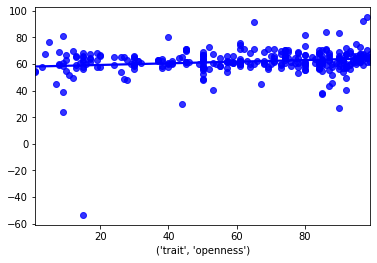


Create pipeline with linear (Fold 5 ), for trait:  openness ...


Score (R squared):  0.11379529714964154 
Mean squared error:  957.8534495266749
Coefficients: 
 [-1.33071309e-02 -9.13603637e-02 -8.03840495e-02  7.72454316e-02
  2.21210184e-02  8.61721580e-02 -1.20044023e-02 -1.19028405e-02
 -6.76730511e-02 -1.38483437e-01 -2.15712480e-02  1.33879966e-01
 -2.39071373e-02  6.91842412e-02  1.19640932e-01  8.93704928e-02
 -2.46869664e-01  3.24342540e-02  4.51086611e-02  1.41532649e-01
 -2.27592129e-01  2.88486532e-02  4.38204481e-02 -3.56477851e-01
  1.52783825e-03 -5.73487162e-02  5.82577084e-02 -8.61808835e-02
  2.08553900e-01 -4.57958120e-02  7.44909369e-02 -5.80867812e-02
 -1.45155430e-04 -3.95646498e-02 -2.07230160e-02  1.47751498e-01
 -7.45897939e-02  2.55263633e-02  8.51534606e-02  1.23024923e-01
  6.00672658e-02  1.06588774e-01  2.65081632e-02  2.74634586e-01
  5.43545249e-02 -2.62946087e-02 -2.28716634e-02 -2.91262347e-02
  2.67748827e-01  1.28889889e-01 -1.55557729e-02 -5.27786

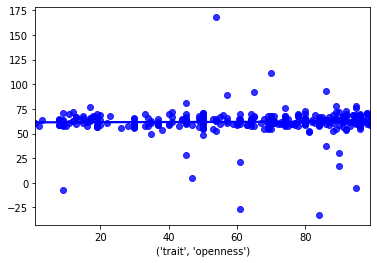

Time for entire process: 54.28s
Average score (R squared):  0.1153315955191668

Trait to predict:  conscientiousness 


Create pipeline with linear (Fold 1 ), for trait:  conscientiousness ...


Score (R squared):  0.0875350807211035 
Mean squared error:  3673.9229167427907
Coefficients: 
 [-0.08686432 -0.0284524  -0.12235982  0.10790162  0.0983924   0.1195624
 -0.02851163  0.05205604  0.0146851   0.03785937 -0.05294862 -0.09531956
 -0.0657209  -0.02947409  0.04671499 -0.05168028 -0.07691874  0.20346186
  0.02374865  0.01918363  0.12353438 -0.05388075 -0.09280132  0.04258452
 -0.10226261 -0.08789004  0.0883272  -0.03736857 -0.17000141  0.03879617
  0.02513391 -0.0404097  -0.09838752  0.03989349 -0.11020894 -0.02878851
 -0.14847351 -0.00526511  0.13843995 -0.16512023 -0.06879901 -0.2044759
  0.05067493  0.00120698  0.03420194 -0.01940048  0.01789095  0.08016372
  0.17571512 -0.34127856  0.22914428 -0.02090867  0.11775373 -0.20846508
 -0.05211105 -0.08150094  0.14800867  0.02318092  0.14

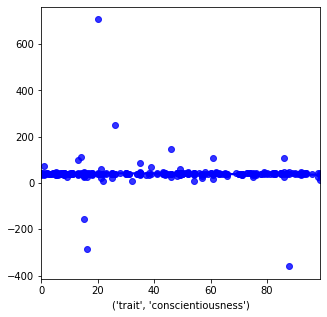


Create pipeline with linear (Fold 2 ), for trait:  conscientiousness ...


Score (R squared):  0.08688236310620212 
Mean squared error:  6163.000112192925
Coefficients: 
 [-0.06808326 -0.04370342  0.0195626   0.02089961 -0.00189395  0.09987978
  0.15471229  0.03707454  0.02259976 -0.070955   -0.02459659 -0.04922179
 -0.13462618  0.03468489 -0.03276455  0.03059936 -0.06001736  0.01354003
 -0.02105227  0.15510512  0.14428026 -0.06597727  0.0332404  -0.0630017
 -0.07342545 -0.04898817 -0.0069615  -0.18367811  0.05383649  0.21542101
 -0.04692424  0.15180322  0.00684477  0.12432151  0.03262419 -0.12747384
  0.10730227 -0.02138652 -0.10991166 -0.14163273  0.04133     0.03054693
 -0.02615372 -0.21981552 -0.03634169  0.12227896  0.07672408  0.05257336
  0.09068311  0.31132646 -0.13511725  0.12919453 -0.08232608 -0.2137266
 -0.09474363 -0.18785069  0.00887304  0.14586868  0.24626083  0.11658249
  0.08972917  0.19743183 -0.06433377 -0.06075272 -0.01369639  0.09564645
 -0.14970546 -0.01318337 -0

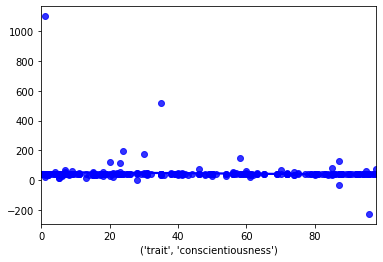


Create pipeline with linear (Fold 3 ), for trait:  conscientiousness ...


Score (R squared):  0.08013991505145512 
Mean squared error:  1904.9442057476651
Coefficients: 
 [-6.43294592e-02 -4.17026816e-05  2.43025450e-02 -6.62667315e-02
  7.39126950e-02  5.89873111e-02  1.19896109e-01  9.08089941e-02
  1.22339193e-01  8.38963230e-02 -5.11740894e-02 -4.16717150e-02
  5.53829411e-02 -8.89094753e-02 -3.80321503e-03 -3.93690351e-02
  2.25404386e-02  7.71199530e-02  1.05572790e-01 -2.73869512e-02
  6.84987747e-02  6.47827710e-02  1.57767699e-01  9.85265524e-02
 -8.05748251e-03 -3.61258909e-02  8.93815633e-02  7.20676229e-02
 -1.12463380e-01  1.53031398e-01  1.40576408e-02 -1.28316257e-01
 -1.22765050e-01 -1.47806295e-01 -1.40552617e-01  1.63055714e-02
  5.29650703e-02  6.21142355e-02  3.24252552e-02  1.78591012e-01
 -6.27994663e-04 -1.43431152e-02 -1.31962387e-01 -1.24399905e-01
 -1.67738845e-01 -1.42506287e-01 -2.89467323e-02 -3.98573147e-02
  5.90165302e-02  5.53166491e-03 -1.37683982e-0

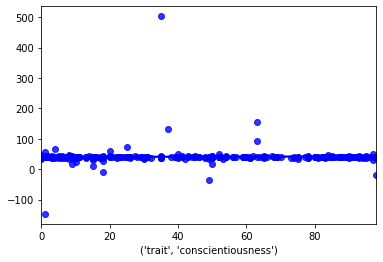


Create pipeline with linear (Fold 4 ), for trait:  conscientiousness ...


Score (R squared):  0.08430421096407914 
Mean squared error:  950.4631589696673
Coefficients: 
 [-0.07118717 -0.02561284  0.0135275  -0.05579871  0.07013642  0.11347831
  0.01328817  0.12083855 -0.02079206  0.17450511 -0.05154169  0.08475222
  0.01604063 -0.10645972 -0.018975   -0.02771633  0.04691412 -0.05285082
  0.03113392  0.09552102  0.01508086 -0.14645504 -0.04717032 -0.0369884
 -0.00951352  0.03863425 -0.00799797  0.06552604  0.02827225 -0.00491157
  0.20377141 -0.06782389  0.05300146  0.15237074  0.1652062   0.04168598
  0.04444524 -0.16994129 -0.0688935  -0.1531213  -0.05969377 -0.17524896
  0.00416864  0.20398806 -0.06658212 -0.0291379  -0.12831538 -0.2176632
 -0.08003788 -0.11229374  0.18599003 -0.08306652 -0.13865305 -0.22847514
  0.03454805  0.17391515 -0.00599404 -0.03024416 -0.01753239  0.16266563
  0.04618551 -0.13091768 -0.26091512  0.0401926   0.04329114 -0.11399368
  0.04332761 -0.00094087 -0

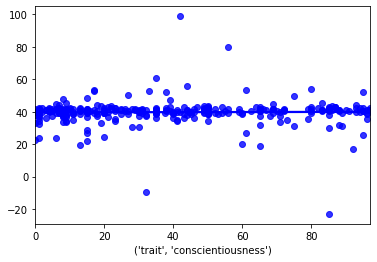


Create pipeline with linear (Fold 5 ), for trait:  conscientiousness ...


Score (R squared):  0.0961731705908524 
Mean squared error:  1634.718067362491
Coefficients: 
 [-0.08229202 -0.08869843  0.00692293  0.04189775  0.03398236  0.07129154
 -0.01642957  0.18254029 -0.01271932  0.03519523  0.02462443 -0.0975335
 -0.03925744 -0.12231225 -0.01956839 -0.03422304 -0.05749414 -0.03633969
  0.12761263  0.06733488  0.09251242 -0.01305581 -0.01997642  0.01764726
  0.10168637  0.02266555 -0.20193402 -0.13046462  0.03725007 -0.02748106
 -0.14824602 -0.13067966 -0.00644129 -0.15480215  0.06127177 -0.12389732
 -0.10054667  0.1111882  -0.10693804 -0.11090254 -0.16647853  0.19513042
  0.06738244  0.0950537   0.02339088 -0.16241379 -0.1203547  -0.13900637
  0.16210229 -0.16010105 -0.1452653  -0.10187534  0.19582281 -0.10034992
 -0.08311052 -0.05014981 -0.16218307 -0.2415692  -0.27167083  0.04947365
  0.04082409  0.05936074  0.06797805 -0.14682624  0.05807751 -0.03139385
  0.25707379 -0.03435135 -0

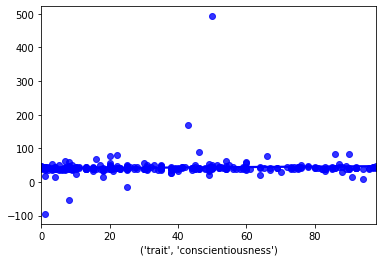

Time for entire process: 109.04s
Average score (R squared):  0.08700694808673845

Trait to predict:  extraversion 


Create pipeline with linear (Fold 1 ), for trait:  extraversion ...


Score (R squared):  0.09008180172690539 
Mean squared error:  7846.984479475505
Coefficients: 
 [-0.03673345  0.00316404 -0.06694268 -0.0876654   0.04261697 -0.08952286
 -0.04450638 -0.03508231  0.01444202 -0.06447662 -0.06102306  0.1729467
 -0.02647927  0.04808084  0.03085949 -0.12749222  0.03268811 -0.13968852
 -0.05070168 -0.06141881 -0.07765866 -0.11591857  0.07992038  0.04314515
 -0.00715973 -0.02278079  0.14840184 -0.07917727 -0.04742064 -0.13908266
  0.00297299 -0.16710917 -0.06650285 -0.04174523 -0.07680986  0.10318217
 -0.1463298   0.20892273  0.10427711 -0.17507282  0.09450688 -0.05115672
 -0.0880347  -0.21577151  0.2197256  -0.0515579   0.21173818  0.08953928
 -0.16332908 -0.09211755 -0.0076046  -0.02671814  0.26739191 -0.10218546
 -0.06612417  0.07608471 -0.05921508  0.19843619 -0.11175696 

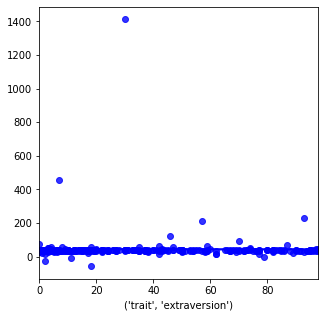


Create pipeline with linear (Fold 2 ), for trait:  extraversion ...


Score (R squared):  0.09184133182084064 
Mean squared error:  6682.973095786003
Coefficients: 
 [-0.07867246 -0.03303844  0.03317256 -0.07996372 -0.0353268  -0.01374735
  0.09368934 -0.01814129  0.00446306 -0.03478709  0.02263251  0.12134209
  0.04899737  0.15061574  0.02820992  0.01295262 -0.11949334 -0.09019817
  0.04323595  0.12219762 -0.0701707   0.09379053 -0.05358942  0.10145349
 -0.05093887  0.05036483  0.06534382 -0.0937936   0.12773328 -0.06737704
 -0.17944049  0.13440907  0.2095865  -0.14374904 -0.00935901 -0.13527313
  0.06331313  0.030917   -0.06112756 -0.08121344  0.18206635 -0.04114327
  0.14888261 -0.09529868 -0.07455169  0.14932211 -0.14872617 -0.06150203
 -0.24222484  0.09676787 -0.02529167 -0.04145503 -0.06641972 -0.27603402
  0.16644075  0.06966033 -0.18226533 -0.06788524 -0.02242449 -0.089623
  0.00801963  0.21008738 -0.16840906  0.09522046  0.18106493  0.00352162
  0.26996359 -0.12399134  0.1245

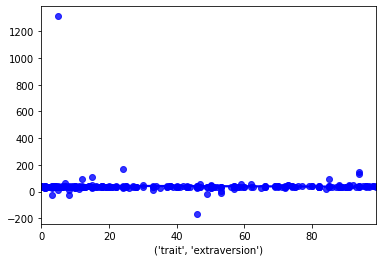


Create pipeline with linear (Fold 3 ), for trait:  extraversion ...


Score (R squared):  0.09314314203244267 
Mean squared error:  2030.577227579987
Coefficients: 
 [-0.07418077  0.01888627 -0.00570623 -0.10056742 -0.04072204 -0.07253551
 -0.02063032  0.10238744 -0.00973228 -0.01240724  0.03696985  0.01921225
 -0.12435182  0.09547688  0.14494717 -0.06566961  0.03714228 -0.10501121
  0.12600304 -0.0923521   0.00114462 -0.05425139 -0.10361632 -0.01109091
  0.02665466 -0.10266865  0.02438897 -0.01574125 -0.12536556 -0.11948096
  0.02001785  0.05920192 -0.11984193 -0.05931163 -0.15182198 -0.08989908
  0.28049908  0.01122414 -0.11118446 -0.07420429  0.11310775  0.02009268
 -0.14326274 -0.03657545 -0.1206328  -0.10373603  0.04128944  0.02388204
  0.27847187 -0.04514465 -0.13266513 -0.20013506 -0.02047006 -0.12877467
 -0.17662916  0.1069674   0.15580096 -0.08862066  0.36440991 -0.21792275
  0.0288479  -0.12052693  0.04692917  0.00132973  0.05013431  0.13606972
 -0.01956254 -0.0502802   0.10

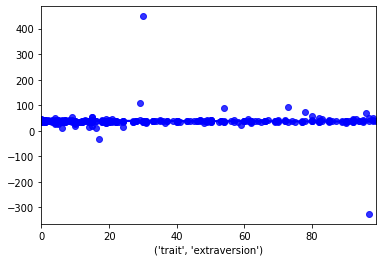


Create pipeline with linear (Fold 4 ), for trait:  extraversion ...


Score (R squared):  0.0916232697560706 
Mean squared error:  958.3104458391107
Coefficients: 
 [-0.06738575  0.01071807 -0.05308054 -0.10463814 -0.06560323 -0.04210342
  0.01822746  0.09720927  0.00487721 -0.01924004 -0.04822801 -0.07644102
 -0.03822436  0.03835212  0.0553363  -0.04821815  0.06268558 -0.08761366
 -0.05499471  0.10630414  0.1194245   0.11039488 -0.02956949  0.01288676
  0.09180264  0.07937072 -0.04585212 -0.06124942 -0.10000041  0.09654196
  0.13180232  0.20488367 -0.09088532  0.0477041  -0.09831984  0.12666316
 -0.00386678 -0.11350845 -0.05519061 -0.19890892 -0.07096201  0.06630022
  0.0049125   0.24391788 -0.07853128 -0.17650739  0.20845224 -0.00279377
  0.04681673 -0.07137941  0.21409912 -0.15661905 -0.03908743  0.14257307
  0.22519725 -0.17507797 -0.10452036 -0.08268418  0.03939437 -0.07923847
  0.09914175 -0.07452919  0.1575175  -0.06716838 -0.17923067  0.23657715
 -0.01277434  0.14771576 -0.001

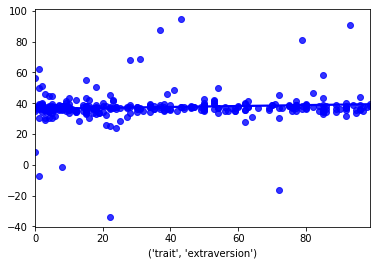


Create pipeline with linear (Fold 5 ), for trait:  extraversion ...


Score (R squared):  0.08936305731955241 
Mean squared error:  1072.9515995473369
Coefficients: 
 [-0.07678639 -0.04771246 -0.00222857 -0.0601809   0.09412715  0.05132865
 -0.05232163 -0.06055791 -0.00889338 -0.09197839  0.02943983  0.03346735
  0.08228182 -0.01480785  0.18432629 -0.03822132 -0.13806452  0.0069888
  0.14663678 -0.02249769 -0.02322087 -0.0359447   0.06460123 -0.07364477
 -0.0115263  -0.19492738  0.06290759 -0.02067225  0.0440472  -0.08266147
 -0.03520173 -0.21334102 -0.07499652 -0.14065325 -0.11710399  0.12427693
  0.06894343  0.07593891 -0.07492892 -0.08400048 -0.18570571 -0.08714449
  0.14653472  0.23982382 -0.0871379  -0.15690507 -0.05283736 -0.04557345
  0.07998286 -0.10721333 -0.08397174 -0.04799192 -0.02580773 -0.09643986
 -0.16757391 -0.10145325 -0.11214392 -0.15923923  0.17793297 -0.13294158
  0.15497581  0.14437792  0.02805234 -0.22322136  0.11734374  0.0180295
  0.012133    0.19348178  0.022

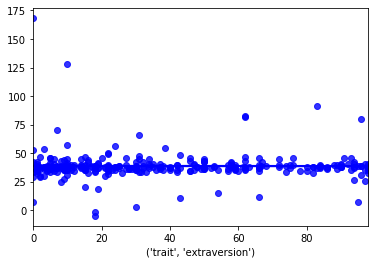

Time for entire process: 163.42s
Average score (R squared):  0.09121052053116234

Trait to predict:  agreeableness 


Create pipeline with linear (Fold 1 ), for trait:  agreeableness ...


Score (R squared):  0.0971309447552271 
Mean squared error:  2356.6486822596944
Coefficients: 
 [ 0.03279033 -0.03763149 -0.06367464  0.00528513  0.06071011  0.10692045
  0.04929165  0.18042192 -0.02907495  0.06007956  0.02841696  0.00362987
 -0.11491797  0.0964246  -0.17100493 -0.08067113 -0.05075797 -0.00486234
  0.09201915 -0.15474228  0.00811269 -0.01030262  0.05551903  0.18039822
  0.01413247  0.1454076   0.08725445  0.13360705  0.08338994 -0.06610315
 -0.1071257   0.10664819 -0.16446566  0.10143562  0.04305252  0.13026333
 -0.02897733 -0.10128493 -0.22362617  0.01732086  0.02440091 -0.29029719
 -0.10664587 -0.02510733 -0.12580292 -0.17136987  0.17908397 -0.14129144
  0.0786154  -0.17650212 -0.01846345 -0.17869616  0.02047473 -0.11289768
  0.04092856  0.02297066 -0.20076886  0.00272327 -0.257082

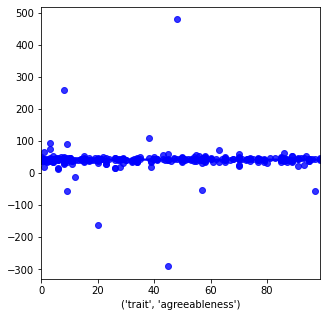


Create pipeline with linear (Fold 2 ), for trait:  agreeableness ...


Score (R squared):  0.09601043714719681 
Mean squared error:  1796.9567475364922
Coefficients: 
 [-5.26245920e-02  1.57338822e-02 -3.53897579e-02  3.09571660e-03
 -1.49609239e-02  4.54211086e-02 -1.22012882e-01  5.40355766e-02
 -9.71121198e-03 -1.39383246e-01 -2.56002447e-02 -4.71233641e-02
 -6.17146465e-02  1.37775197e-01  8.89206638e-02 -1.69514637e-01
 -5.10324206e-02  5.22227536e-02 -1.28534805e-01  9.33512244e-02
  8.02274056e-02 -3.80097118e-02 -1.02179833e-01  1.43150265e-01
  9.78028565e-03 -1.02439284e-02  3.05670931e-02 -4.31349723e-02
 -1.08279978e-01 -2.25689781e-01  1.37268309e-01 -3.99025681e-02
  2.16127557e-01 -2.82193991e-02  1.39874020e-01 -1.75903493e-01
  9.40424721e-02  4.39701385e-02 -1.72670883e-01 -8.99697156e-02
 -1.11270031e-01 -6.31140585e-02 -3.10590146e-02  3.85066296e-01
 -1.20178807e-01 -2.10115693e-01 -9.03741780e-02  3.72504019e-02
 -8.37647608e-02 -2.77644766e-01  4.37827675e-02  2

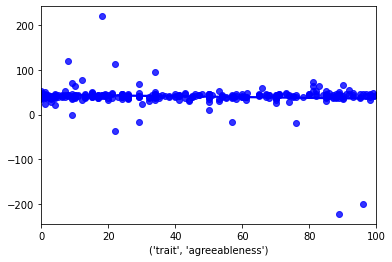


Create pipeline with linear (Fold 3 ), for trait:  agreeableness ...


Score (R squared):  0.10390891343839292 
Mean squared error:  1467.5053327216115
Coefficients: 
 [-0.04654452  0.07914124 -0.0062944  -0.03631371  0.00603708 -0.01546628
  0.12950776 -0.12712711  0.10043765 -0.0489534  -0.06982301 -0.0800576
  0.12503368 -0.03729677  0.11321352 -0.06653438 -0.1444594  -0.03490638
  0.08845472 -0.05502667 -0.07293465  0.06787917  0.08244587 -0.07145715
  0.20076865 -0.0234526   0.06991974  0.0464629  -0.07527545 -0.18534688
 -0.02016602 -0.05282162  0.05757944  0.09979345  0.13325405 -0.12634037
  0.08299812 -0.0669111  -0.26111237 -0.07501359 -0.09527068 -0.00914496
 -0.09841451 -0.19273556  0.07718538 -0.19716287 -0.20201816 -0.00716019
 -0.1947624  -0.08563641 -0.04317998  0.25719506  0.03507781  0.16681823
 -0.15216797  0.20766187 -0.02673374 -0.09004528  0.02471845 -0.23863525
  0.01725805  0.01597603 -0.13322723 -0.09137614  0.08175337  0.14999188
  0.04841892  0.05860275  0.2

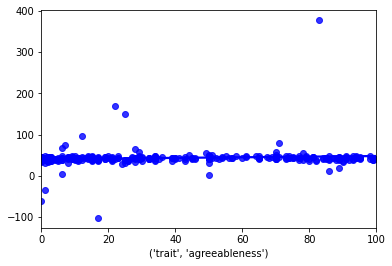


Create pipeline with linear (Fold 4 ), for trait:  agreeableness ...


Score (R squared):  0.10611391684531701 
Mean squared error:  1039.3037917874922
Coefficients: 
 [-0.06561659  0.01584027 -0.02509364 -0.02098539  0.01564838  0.03208195
  0.11614056 -0.08986885  0.04518695  0.11365034 -0.0789083   0.17085071
  0.05464083 -0.10009652  0.1275179  -0.05771703 -0.12446037 -0.1177871
 -0.00274364  0.04009051  0.10467932 -0.11995301  0.01755823 -0.04043918
  0.09968409  0.0906521  -0.0156422   0.05036138 -0.04338183  0.14695901
 -0.16860349  0.17124238 -0.11886709 -0.08807514 -0.22852265 -0.16604963
 -0.14347077 -0.14524728 -0.04464587 -0.19200793 -0.198718    0.0344738
 -0.07993909 -0.01558951 -0.14956568 -0.20074377 -0.25045289 -0.18017213
 -0.05571732 -0.31060113  0.06963618 -0.01850749 -0.15366816 -0.00200537
  0.00593449 -0.01538784  0.06233385 -0.1865774   0.07583511 -0.24839136
  0.23900109  0.15024689  0.19083079  0.01761687  0.0694379   0.22003893
 -0.09585571 -0.01513886 -0.04

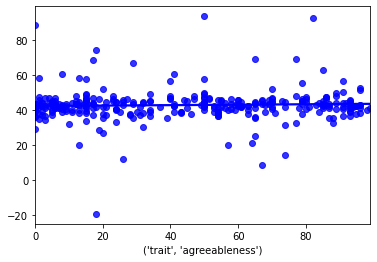


Create pipeline with linear (Fold 5 ), for trait:  agreeableness ...


Score (R squared):  0.10157748438236436 
Mean squared error:  1200.9857117226568
Coefficients: 
 [-0.06481604  0.00367176 -0.00654006  0.01352643  0.02379178 -0.1341459
  0.06102327  0.14729241 -0.07376135  0.09523049  0.09211862 -0.12438573
  0.12162079 -0.07592221  0.06211837 -0.05737657 -0.06039595 -0.04589888
  0.10640718 -0.01609007  0.01887387  0.02143224  0.16501595 -0.07706122
  0.07615078 -0.08030812  0.11385995  0.1909911  -0.13813797  0.09224708
  0.03753723 -0.07931559 -0.04761259  0.19320986 -0.16456865  0.17416928
 -0.10691423  0.03195443 -0.08992657 -0.06914172 -0.0957686   0.01793717
 -0.30470082 -0.03329233 -0.3136394  -0.20807389  0.03739247 -0.18294928
 -0.10987927 -0.25213315  0.04253171  0.06622438 -0.02787997  0.03916205
 -0.00354557 -0.23255504  0.11239296 -0.05448295  0.187458   -0.16639978
 -0.06110756  0.1768925  -0.03640314 -0.27595426 -0.07204378  0.07425871
 -0.17373043 -0.05295034  0.0

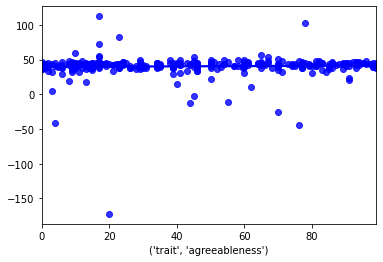

Time for entire process: 218.39s
Average score (R squared):  0.10094833931369965

Trait to predict:  neuroticism 


Create pipeline with linear (Fold 1 ), for trait:  neuroticism ...


Score (R squared):  0.08920277351749428 
Mean squared error:  3222.2437195438933
Coefficients: 
 [ 0.03946688 -0.05708126  0.11012305  0.00704336 -0.0704971   0.08690116
 -0.05445387 -0.02930981 -0.00847352  0.10960685 -0.05244841 -0.01740634
  0.0364652   0.03717133 -0.05059031  0.06418322 -0.03151392 -0.12801948
 -0.16859179 -0.14584395 -0.04375949  0.06899393 -0.0871443   0.1171626
  0.24126625 -0.04531864 -0.29772174  0.03959007  0.03482579  0.03834396
 -0.26139748  0.12673496  0.05152485 -0.05039406  0.2887831  -0.05047773
  0.15946036  0.1117135  -0.1204104   0.0591957   0.07639797  0.12256133
 -0.12127188  0.1029835  -0.04909527  0.08707231 -0.00290135 -0.00336605
  0.22843212  0.05183813 -0.1133986   0.07720299 -0.12030397  0.05347005
 -0.22336752  0.14821374 -0.10063277  0.02708051 -0.2383357  -

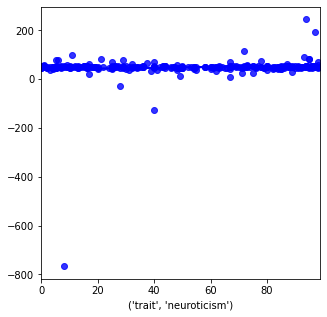


Create pipeline with linear (Fold 2 ), for trait:  neuroticism ...


Score (R squared):  0.09759287407367578 
Mean squared error:  18463.95597099669
Coefficients: 
 [ 0.04524126  0.05565838  0.09290435 -0.02440844  0.0771079  -0.00961864
 -0.11687179  0.05963449 -0.04817888  0.01850113  0.00317252  0.08745893
 -0.11617086 -0.05411127  0.0454555  -0.03063721  0.09493195 -0.04377846
 -0.04318689  0.06419902 -0.22923842 -0.14434377  0.08670046 -0.04681388
  0.071855    0.16776851  0.21634439  0.24619963  0.0742908  -0.12902861
  0.12722503 -0.06936707 -0.18824269 -0.11256354  0.09519883  0.11608827
 -0.09343332  0.1060557   0.01999891  0.20460116  0.06593743 -0.17275205
 -0.12192745  0.19092434 -0.07744984 -0.10607967  0.03453047 -0.14319893
  0.03625132  0.02632943  0.11944912 -0.08637569  0.29403026 -0.16846343
 -0.07370829  0.10915671 -0.06607777  0.15637978 -0.42264309 -0.13565877
 -0.01139    -0.04910374  0.06995062  0.16192177 -0.14722051  0.08812595
 -0.22223048 -0.00588463 -0.061

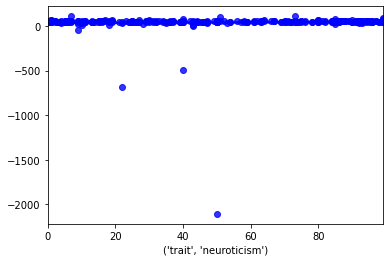


Create pipeline with linear (Fold 3 ), for trait:  neuroticism ...


Score (R squared):  0.09103021480991902 
Mean squared error:  7678.139260351716
Coefficients: 
 [ 0.04666846  0.02643326  0.12745212  0.06185085 -0.13382312  0.0813554
 -0.00768467 -0.13545697  0.00170418  0.05675763  0.09476582 -0.04239
 -0.00292576  0.02758901 -0.04964984  0.08139843 -0.0611758   0.07568613
  0.04107222 -0.10037199 -0.00158452 -0.25883938 -0.00428681  0.02082189
  0.01578706  0.21514005  0.06835006 -0.06644618  0.27063184 -0.17387276
  0.11645097  0.14419075 -0.03819562 -0.04206134  0.0603899  -0.04886721
 -0.2702178  -0.12690339  0.04709357 -0.05934815  0.0642863  -0.01168296
 -0.04981657  0.06073152  0.25005645  0.12639643 -0.01184261  0.16949392
 -0.18573137  0.03294332  0.07171304  0.11017732 -0.17331324 -0.13344748
 -0.00847513  0.03303803  0.0636835  -0.03965478 -0.17692652  0.02644217
  0.15399214  0.15141806 -0.00962331  0.08856147 -0.18116901 -0.01393221
 -0.08829812  0.34756328 -0.0692576

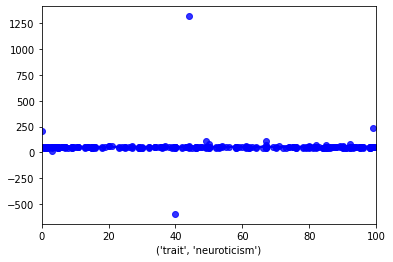


Create pipeline with linear (Fold 4 ), for trait:  neuroticism ...


Score (R squared):  0.08596331755560194 
Mean squared error:  1075.1882617363476
Coefficients: 
 [ 0.03534557  0.0302093   0.07200778  0.05374417 -0.11002824  0.02951066
 -0.01258859 -0.1268438  -0.04177838  0.11624334 -0.05407635 -0.02595824
 -0.06429131  0.09101308  0.0206703   0.05247784 -0.08067899  0.04778442
  0.04980318 -0.02940761  0.13442658  0.15253167 -0.13964135  0.01447036
  0.09296399 -0.14690575 -0.12458211 -0.00713625 -0.15481284 -0.14250632
 -0.08703795  0.00664307  0.11145209 -0.2631188   0.00704781 -0.04596712
 -0.06766799  0.27109703  0.01946553  0.1088087  -0.03399111  0.25877308
  0.00924322 -0.2029538   0.00599937 -0.11541381  0.06970815 -0.0575844
 -0.11744539 -0.21722604 -0.01328483 -0.0256716  -0.03248302  0.01726019
  0.01005713  0.16086226  0.14626691  0.08178554 -0.10879639 -0.16777422
  0.1974841  -0.04178838  0.07437811  0.11497087 -0.40681486  0.02956955
  0.06986041 -0.08802362 -0.191

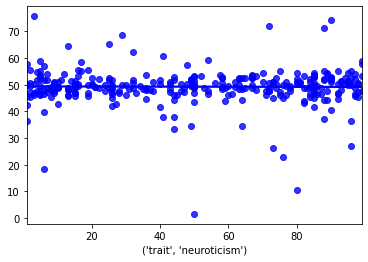


Create pipeline with linear (Fold 5 ), for trait:  neuroticism ...


Score (R squared):  0.095120002402176 
Mean squared error:  1224.3485164374038
Coefficients: 
 [ 6.06289481e-02  7.40811797e-02  7.87849726e-02 -9.97101924e-02
  1.92634668e-04 -2.53377203e-02  1.81448866e-01  8.14760749e-03
 -9.14497917e-03  6.61232469e-03 -1.27300776e-02  9.59346649e-02
  1.61910590e-02 -1.06979522e-01 -4.44749723e-02  6.36204486e-02
  4.93163656e-02  6.23670223e-02  3.09715717e-02 -1.55549341e-01
  9.27217937e-02 -9.80791020e-02  5.21615398e-02  1.06292464e-01
 -4.32278038e-02  4.89883700e-02  3.05178796e-01  5.80704202e-02
  5.52267224e-02 -1.25052358e-02 -1.08039731e-01  2.44144394e-01
 -6.05227650e-02  2.21694532e-01  3.64338506e-02  2.58756063e-03
  1.19062534e-01 -7.26762557e-02  2.13045003e-02 -1.88968497e-02
  1.87973007e-01 -2.25341358e-01 -9.00910964e-02 -1.61691176e-01
 -1.06962739e-02 -1.54195860e-02 -1.77170019e-01  7.18142643e-02
 -1.00635278e-02 -7.57828286e-02  2.25107198e-01  2.230

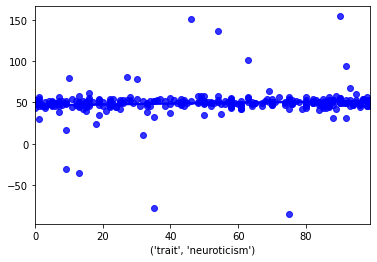

Time for entire process: 273.63s
Average score (R squared):  0.0917818364717734
Classifier:  rfc_reg 


Trait to predict:  openness 


Create pipeline with rfc_reg (Fold 1 ), for trait:  openness ...


Score (R squared):  0.8607895370319778 
Mean squared error:  786.8593109872612


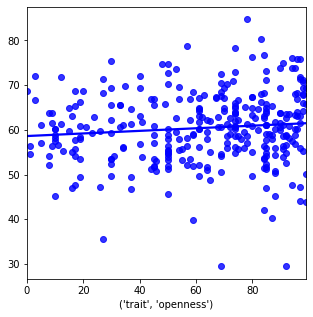


Create pipeline with rfc_reg (Fold 2 ), for trait:  openness ...


Score (R squared):  0.8571010116970064 
Mean squared error:  815.9930963375797


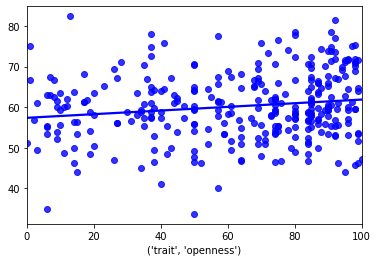


Create pipeline with rfc_reg (Fold 3 ), for trait:  openness ...


Score (R squared):  0.8659302331994615 
Mean squared error:  769.0596191878981


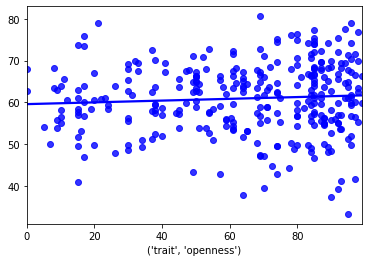


Create pipeline with rfc_reg (Fold 4 ), for trait:  openness ...


Score (R squared):  0.8610106874819831 
Mean squared error:  771.2277955271566


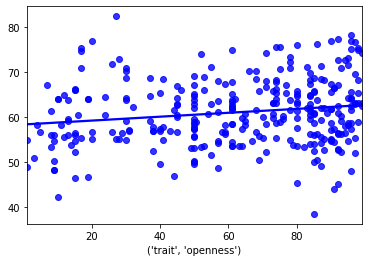


Create pipeline with rfc_reg (Fold 5 ), for trait:  openness ...


Score (R squared):  0.8623869104987197 
Mean squared error:  817.0457976837062


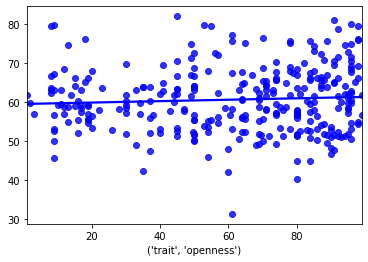

Time for entire process: 332.75s
Average score (R squared):  0.8614436759818297

Trait to predict:  conscientiousness 


Create pipeline with rfc_reg (Fold 1 ), for trait:  conscientiousness ...


Score (R squared):  0.8610187127994738 
Mean squared error:  894.4642867834394


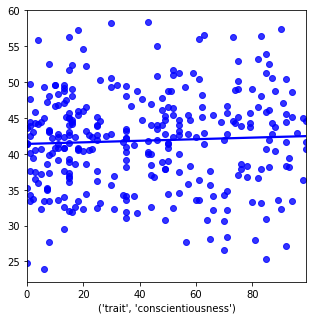


Create pipeline with rfc_reg (Fold 2 ), for trait:  conscientiousness ...


Score (R squared):  0.86006220712683 
Mean squared error:  1000.540464490446


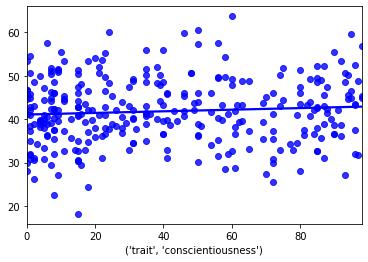


Create pipeline with rfc_reg (Fold 3 ), for trait:  conscientiousness ...


Score (R squared):  0.859108000177657 
Mean squared error:  1026.431912420382


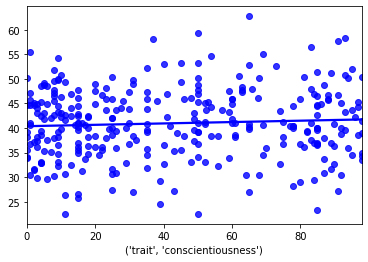


Create pipeline with rfc_reg (Fold 4 ), for trait:  conscientiousness ...


Score (R squared):  0.8583976496726483 
Mean squared error:  872.2771195686901


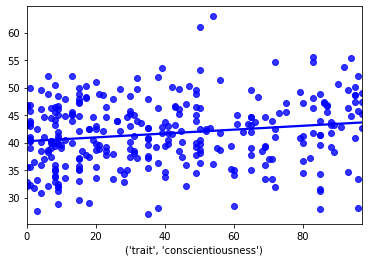


Create pipeline with rfc_reg (Fold 5 ), for trait:  conscientiousness ...


Score (R squared):  0.8601319823939745 
Mean squared error:  857.611247683706


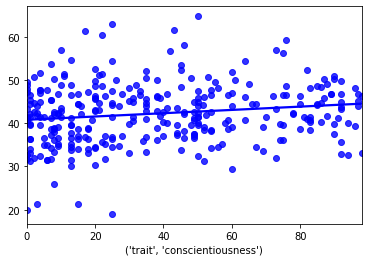

Time for entire process: 392.77s
Average score (R squared):  0.8597437104341166

Trait to predict:  extraversion 


Create pipeline with rfc_reg (Fold 1 ), for trait:  extraversion ...


Score (R squared):  0.8632843383142901 
Mean squared error:  877.4618441878981


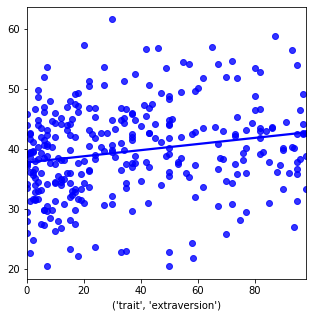


Create pipeline with rfc_reg (Fold 2 ), for trait:  extraversion ...


Score (R squared):  0.8599209527203504 
Mean squared error:  930.6937385350318


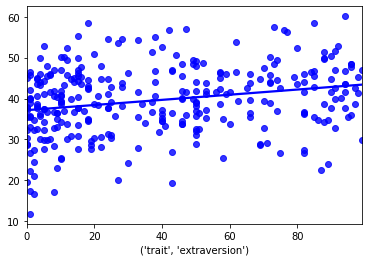


Create pipeline with rfc_reg (Fold 3 ), for trait:  extraversion ...


Score (R squared):  0.8656448616102088 
Mean squared error:  921.4152064490446


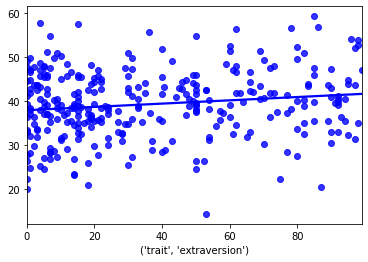


Create pipeline with rfc_reg (Fold 4 ), for trait:  extraversion ...


Score (R squared):  0.8654584796702726 
Mean squared error:  915.261080031949


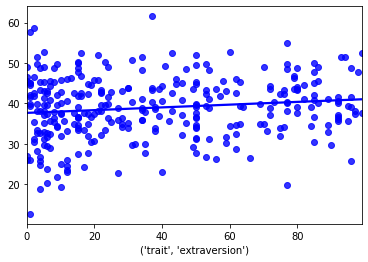


Create pipeline with rfc_reg (Fold 5 ), for trait:  extraversion ...


Score (R squared):  0.860909965508013 
Mean squared error:  880.417405830671


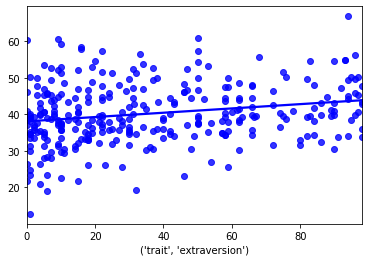

Time for entire process: 455.96s
Average score (R squared):  0.863043719564627

Trait to predict:  agreeableness 


Create pipeline with rfc_reg (Fold 1 ), for trait:  agreeableness ...


Score (R squared):  0.8625668001056215 
Mean squared error:  950.0735573248406


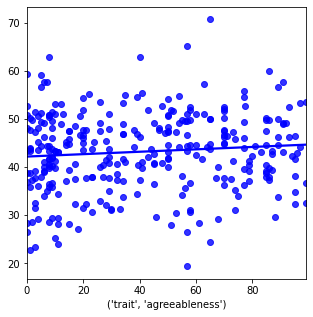


Create pipeline with rfc_reg (Fold 2 ), for trait:  agreeableness ...


Score (R squared):  0.8631057059391382 
Mean squared error:  931.3596234076432


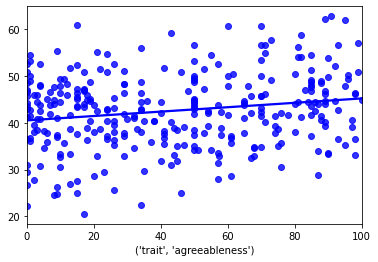


Create pipeline with rfc_reg (Fold 3 ), for trait:  agreeableness ...


Score (R squared):  0.8620677838318871 
Mean squared error:  997.2551683917197


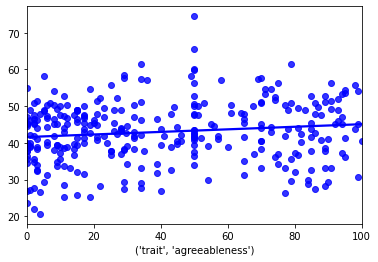


Create pipeline with rfc_reg (Fold 4 ), for trait:  agreeableness ...


Score (R squared):  0.8617715571945146 
Mean squared error:  955.1325408945687


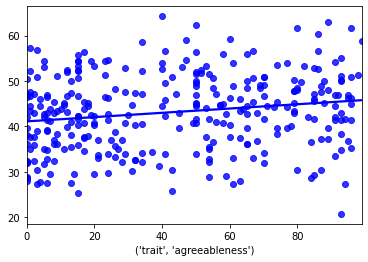


Create pipeline with rfc_reg (Fold 5 ), for trait:  agreeableness ...


Score (R squared):  0.8664611989468233 
Mean squared error:  907.1993893769969


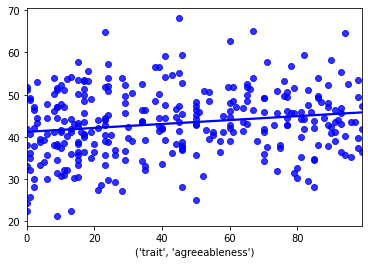

Time for entire process: 518.06s
Average score (R squared):  0.8631946092035969

Trait to predict:  neuroticism 


Create pipeline with rfc_reg (Fold 1 ), for trait:  neuroticism ...


Score (R squared):  0.8605779182077855 
Mean squared error:  1025.259230812102


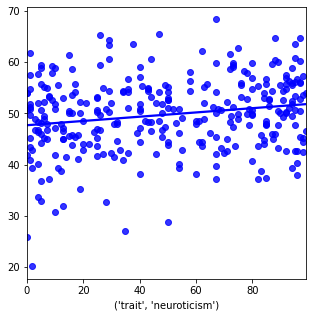


Create pipeline with rfc_reg (Fold 2 ), for trait:  neuroticism ...


Score (R squared):  0.8633736628357641 
Mean squared error:  1090.4350295382167


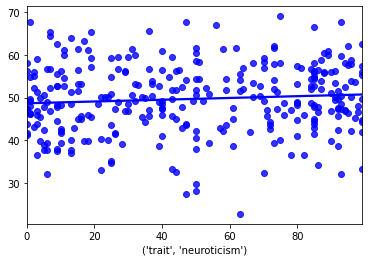


Create pipeline with rfc_reg (Fold 3 ), for trait:  neuroticism ...


Score (R squared):  0.8614219457805337 
Mean squared error:  1062.9189435509554


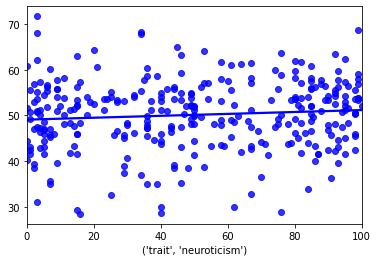


Create pipeline with rfc_reg (Fold 4 ), for trait:  neuroticism ...


Score (R squared):  0.8596796564948833 
Mean squared error:  1008.7318905750799


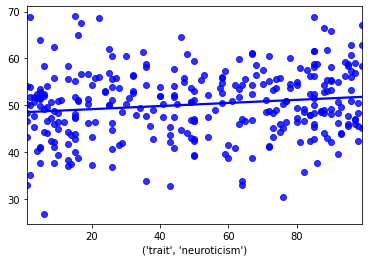


Create pipeline with rfc_reg (Fold 5 ), for trait:  neuroticism ...


Score (R squared):  0.8626217783803126 
Mean squared error:  1027.0455291533547


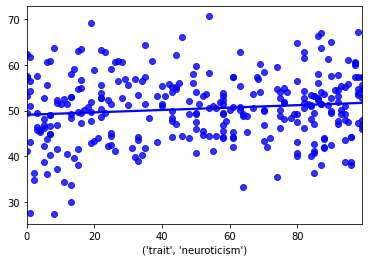

Time for entire process: 581.20s
Average score (R squared):  0.861534992339856


In [20]:
classify_cv(df, big5_traits, 'linear', regres, 'forward_sequential', dim=True, n_feat=10)

https://scikit-learn.org/stable/auto_examples/ensemble/plot_stack_predictors.html#sphx-glr-auto-examples-ensemble-plot-stack-predictors-py

## New approach

In [ ]:
print("LR with mutual info feature selection")
classify_cv(df, big5_traits, 'binary', new_clf, 'mutual', dim=False, n_feat=10)

In [ ]:
print("LR with backward sequential feature selection and pca")
classify_cv(df, big5_traits, 'binary', new_clf, 'sequential_backward', dim=True, n_feat=10)

## Histogram of true traits

In [ ]:
def check_imbalance(df, traits):
    length = len(df)
    o = df['trait', 'big5_o']
    c = df['trait', 'big5_c']
    e = df['trait', 'big5_e']
    a = df['trait', 'big5_a']
    n = df['trait', 'big5_n']
    binarylst = [o, c, e, a, n]
    o5 = df['trait', 'big5_o_multi']
    c5 = df['trait', 'big5_c_multi']
    e5 = df['trait', 'big5_e_multi']
    a5 = df['trait', 'big5_a_multi']
    n5 = df['trait', 'big5_n_multi']
    multilst = [o5, c5, e5, a5, n5]
    
    result = []
    for trait in binarylst: 
        result.append(np.bincount(trait) / length)
    result5 = []
    for trait in multilst:
        result5.append(np.bincount(trait) / len(trait))
    
    print("Distribution of the true trait values in the classes (in %):\n")
    for i in range(len(traits)):
        print(traits[i], "\n\tBinary: ", result[i], "\n\t5 classes: ", result5[i], "\n")
    
#     result =np.bincount(o) / len(o)
#     result5 =np.bincount(o5) / len(o)
#     print("Openness\n\tBinary: ", result, "\n\t5 classes: ", result5)

    
check_imbalance(df, traits)

In [ ]:
# true histogram plots
all_hist_true(df)